# Exploratory Data Analysis

*Author: Nicole Lin*

### Goals

Use Erin's detailed violation and enforcement records exports to 
1. check data quality
2. validate Erin's notes on regional differences in MMP enforcement
2. exploratory data analysis on permits, violations, enforcements, and violation rates

---
### Main Questions
1. Validation
    - Confirm the state initiative push in 2008: did Regions 2, 3, 4  exhibit sharp rises in MMP enforcement actions (ones labeled SWB, OE, EXEC per the order number, IIRC)?  Did Region 5 in fact carry out its own initiative?
    - Confirm the state initiative push in 2013 for Regions 1, 3, 7.
    - Are general permittees brought in ~2006? 
    - Does late reporting change starting in 2004 as well?  Or with the enforcement initiatives?

2. Evaluation
    - Regional Level
        - Count of effluent and MMP violations across time, overall then by region
        - Count of effluent and MMP violation enforcements across time, overall then by region 
        - Effluent and MMP violations enforcement rate before and after 2000, overall then by region
        - Effluent and MMP violations enforcement rate within 3, 6, 12, 18 months of violation occurrence before and after 2000, overall then by region
        - Count of active permits eligible for MMP regulations across time, overall then by region
        - Count of active major wastewater treatment plants eligible for MMP regulations across time, overall then by region
        - Effluent violation rate, MMP serious violation rate, MMP chronic violation rate, reporting violation rate, MMP reporting violation rate, non-MMP violation rates, across time, overall then by regions

    - WWTP 
        - Basic info of WWTP: counts over time, counts by region, locations (map), active age
        - Enforcement rates of WWTP compared to other facilities
        - Time to enforcements of WWTP compared to other facilities
        - Violation rates conditional on WWTP that were always active throughout the period
        - Pre-2000 violation rates: will probably run into MMP inference issues. Might need to use ICIS data

  
---  
### Data

- Detailed_Violation_Report.xlsx: Direct export from CIWQS by Erin. This file contains basic violation information and associated enforcement records since 1990.

- violations_export_2021-10-26.xlsx: violation flat file covering all water permits. This file contains MMP violation flag and NPDES permit id since 2000. 

- facility_reports_2021-12-07_121004_514767.csv: facility list with historical versions scraped from CIWQS Facility-At-A-Glance public reports. Output of https://github.com/reglab/ca_mmp/blob/main/notetbooks/scrape_ca_facility_data.ipynb

---
### Results

#### Validation

- Agreements:
    - MMP enforcement for late reporting violations started in 2004.
    - Region 9 has implemented the MMP themselves from the beginning.
    - 2008 MMP initiative drives up the number of enforcements in Region 2, 3, and 4 (see figure below).
    - SWB helped Region 2, 3, and 4 push out many penalty letters.
    - Region 5 pushed out the initiative themselves. 
- Disagreements:
     - Erin mentioned that general permits are brought into the program in 2006, but MMP enforcement records for general permits span from 2001 to 2004. 


## Read data

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from scipy import stats
import sqlalchemy as sa
import datetime as dt

# set up connection with the database
DB_URI = os.getenv('EPA_DWH')
ENGINE = sa.create_engine(DB_URI)

# display all columns
pd.set_option('display.max_columns', None)

# turn off warning messages
import warnings
warnings.filterwarnings('ignore')

In [4]:
# read violation data
data_dir = os.path.join('~', 'sherlock_oak', 'EPA', 'Data', 'manual', 'california')
detailed = pd.read_excel(os.path.join(data_dir, 'Detailed_Violation_Report.xlsx'))
## fixed column name
detailed = detailed.rename(columns = {' Date Occured': 'Date Occured'})
flat = pd.read_excel(os.path.join(data_dir, 'violations_export_2021-10-26.xlsx'))

In [25]:
# facility data 
facility = pd.read_csv(os.path.join(data_dir, 'Regualted_Facility_Report_Detail_2021-11-17.csv'))
facility_scraped = pd.read_csv(os.path.join(data_dir, 'facility_reports_2021-12-07_121004_514767.csv'))

## Data processing and check data quality 

### Violation and enforcement data

In [6]:
# detailed violation records with enforcement data, pulled from CIWQS internal data portal. Provided by Erin
detailed.head()

,RB,Responsible Party,Place (Facility),WDID,Violation ID,Violation Type,Priority Violation,Violation Program,Status,Date Occured,Violation Description,Comments,Corrective Action,Enforcement Action ID,Enforcement Action,EA Order Number,EA Effective Date,County,Staff,Discovery Date,Unnamed: 20
0,2,Unocal Corporation San Ramon,"Unocal Chemicals Div, GP",NaN,134892,Reporting -> Deficient Reporting,N,NaN,Violation,1999-09-06 00:00:00,Failure to submit Y2K readiness report.,NaN,NaN,227514,13267 Letter,UNKNOWN,1999-10-29 00:00:00,Alameda,Rico Duazo,1999-09-06 00:00:00,NaT
1,2,Industrial Asphalt Calmat,52 El Charro Rd-GW Rechrge,NaN,134893,Reporting -> Deficient Reporting,N,NaN,Violation,1999-09-06 00:00:00,Failure to submit Y2K readiness report.,NaN,NaN,227515,13267 Letter,UNKNOWN,1999-10-29 00:00:00,Alameda,Rico Duazo,1999-09-06 00:00:00,NaT
2,2,Pacific Racing Association,Golden Gate Fields - Recycled Water & Re-Use,2 019261001,134894,Reporting -> Deficient Reporting,N,REC,Violation,1999-09-06 00:00:00,Failure to submit Y2K readiness report.,NaN,NaN,227516,13267 Letter,13267 Letter,1999-10-29 00:00:00,Alameda,Rico Duazo,1999-09-06 00:00:00,NaT
3,2,Ridgemont Development Company,Leona Heights Sulfur Mine,2 019279001,134895,Reporting -> Deficient Reporting,N,LNDISP,Violation,1999-09-06 00:00:00,Failure to submit Y2K readiness report.,NaN,NaN,227517,13267 Letter,UNKNOWN,1999-10-29 00:00:00,Alameda,Rico Duazo,1999-09-06 00:00:00,NaT
4,2,New Century Beverage Company,Bottling Group LLC,2 019320001,134896,Reporting -> Deficient Reporting,N,NPDESWW,Violation,1999-09-06 00:00:00,Failure to submit Y2K readiness report.,NaN,NaN,227518,13267 Letter,UNKNOWN,1999-10-29 00:00:00,Alameda,Rico Duazo,1999-09-06 00:00:00,NaT


In [7]:
detailed['Date Occured'] = pd.to_datetime(detailed['Date Occured'], errors = 'coerce')
sum(detailed['Date Occured'].isna())

4

> a small number of rows are not read properly. We will remove them for now.

In [8]:
detailed = detailed[~detailed['Date Occured'].isna()]

In [9]:
detailed['Date Occured'].sort_values()

44785    1880-01-01
288081   1900-01-01
45116    1952-06-01
78180    1960-01-01
49500    1968-01-01
            ...    
411844   2021-10-18
411843   2021-10-18
411661   2021-10-20
254484   2021-10-22
254441   2021-10-22
Name: Date Occured, Length: 411933, dtype: datetime64[ns]

> detailed violation records go all the way back to the 1900s. The earliest dates must be data errors because the Clean Water Act came to existence in 1972. 

In [10]:
# violation flat file with detailed facility information and aggregated enforcement records
flat.head()

,VIOLATED FACILITY REGION,REGULATED FACILITY REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,FACILITY TYPE,AGENCY TYPE,NUMBER OF AGENCIES,PLACE ADDRESS,PLACE CITY,PLACE ZIP,PLACE COUNTY,PLACE LATITUDE,PLACE LONGITUDE,SIC CODE 1,SIC DESC 1,SIC CODE 2,SIC DESC 2,SIC CODE 3,SIC DESC 3,NAICS CODE 1,NAICS DESC 1,NAICS CODE 2,NAICS DESC 2,NAICS CODE 3,NAICS DESC 3,NUMBER OF PLACES,DESIGN FLOW,THREAT TO WATER QUALITY,COMPLEXITY,PRETREATMENT,FACILITY WASTE TYPE,FACILITY WASTE TYPE 2,FACILITY WASTE TYPE 3,FACILITY WASTE TYPE 4,PROGRAM,PROGRAM CATEGORY,NUMBER OF PROGRAMS,WDID,REG MEASURE ID,REG MEASURE TYPE,TITLE,DESCRIPTION,ORDER NUMBER,NPDES# CA#,MAJOR-MINOR,NPDES TYPE,RECLAMATION,DREDGE FILL FEE,301H,APPLICATION FEE AMT RECEIVED,STATUS,STATUS DATE,EFFECTIVE DATE,EXPIRATION/REVIEW DATE,TERMINATION DATE,ADOPTION DATE,WDR REVIEW - AMEND,WDR REVIEW - REVISE/RENEW,WDR REVIEW - RESCIND,WDR REVIEW - NO ACTION REQUIRED,WDR REVIEW - PENDING,WDR REVIEW - PLANNED,STATUS ENROLLEE,INDIVIDUAL/GENERAL,FEE CODE,STAFF ASSIGNED,NUMBER OF STAFF ASSIGNED,SUPERVISOR,NUMBER OF SUPERVISORS,VIOLATION ID (VID),VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,VIOLATION COMMENTS,CORRECTIVE ACTION,STATUS.1,OCCURRED ON,DISCOVERY DATE,PROGRAM.1,PROGRAM CATEGORY.1,PRIORITY (Y/N),NPDES Serious (Y/N),Otherwise MMP (Y/N),EXEMPT (Y/N),Reason Exempt from MMPs,MMP TYPE,QNCR Reportable,Violation Source,Violation Source ID,Violation Rank,Parameter,Limit,Result,Units,Period,Monitoring Location,Number of Final (A+H) 13267,Number of Final (A+H) 13308,Number of Final (A+H) ACL,Number of Final (A+H) CDO,Number of Final (A+H) CAO,Number of Final (A+H) Expedited Payment Letters,Number of Final (A+H) Referrals to Attorney General,Number of Final (A+H) Notices of Stormwater Noncompliance,Number of Final (A+H) Notices of Violation,Number of Final (A+H) Notices to Comply,Number of Final (A+H) Oral Communications,Number of Final (A+H) Referrals to District Attorney,Number of Final (A+H) Referrals to Other Agency,Number of Final (A+H) Referrals to Task Force,Number of Final (A+H) Referrals to USEPA,Number of Final (A+H) Settlement Court Orders,Number of Final (A+H) Staff Enforcement Letter,Number of Final (A+H) Stipulated Penalties,Number of Final (A+H) Third Party Actions,Number of Final (A+H) Time Schedule Orders,Number of Final (A+H) Unknown,Number of Final (A+H) Waste Discharge Requirements
0,5F,5F,273099.0,Porterville Nuckols Reclamation Project,Porterville City & R Nuckols,Utility,Recycled Water Use Area,Agricultural,City Agency,1.0,W of Porterville Airport,Porterville,93258,Tulare,36.03521,-119.06845,191.0,"General Farms, Primarily Crop",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2.0,C,N - POTW does not have EPA approved pretreatme...,Domestic wastewater,NaN,NaN,NaN,REC,WDR,1.0,5D540133001,131131.0,Reclamation Requirements,WRR 01-246 for City of Porterville & R. Nuckols,Recycler of Porterville WWTF effluent,01-246,NaN,NaN,NaN,3 - User,NaN,NaN,NaN,Active,2001-10-19,2001-10-19,2011-10-19,NaT,2001-10-19,NaT,NaT,NaT,NaT,NaT,NaN,N,I,20 - Non Billable Users of Recycled Water,NaN,NaN,NaN,NaN,221921,Reporting,Deficient Reporting,Missing Amount of fertilizer used.,NaN,NaN,Violation,2002-06-30,2002-06-12 00:00:00,REC,WDR,N,N,N,N,NaN,NaN,N,Inspection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5F,5F,273099.0,Porterville Nuckols Reclamation Project,Porterville City & R Nuckols,Utility,Recycled Water Use Area,Agricultural,City Agency,1.0,W of Porterville Airport,Porterville,93258,Tulare,36.03521,-119.06845,191.0,"General Farms, Primarily Crop",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,2.0,C,N - POTW does not have EPA approved pretreatme...,Domestic wastewater,NaN,NaN,NaN,REC,WDR,1.0,5D540133001,131131.0,Reclamation Requirements,WRR 01-246 for City of Porterville & R. Nuckols,Recycler of Porterville WWTF effluent,01-246,NaN,NaN,NaN,3 - User,NaN,NaN,NaN,Active,2001-10-19,2001-10-19,2011-10-19,NaT,2001-10-19,NaT,NaT,NaT,N

In [11]:
# check whether there are missing violation ids
sum(flat['VIOLATION ID (VID)'].isna())

0

In [12]:
flat['OCCURRED ON'].sort_values()

97277    2000-01-01
144707   2000-01-01
162403   2000-01-01
342896   2000-01-01
408355   2000-01-01
            ...    
290172   2021-10-24
256998   2021-10-24
164106   2021-10-24
125926   2021-10-24
125924   2021-10-25
Name: OCCURRED ON, Length: 417612, dtype: datetime64[ns]

> the flat file only contains violations after 2000

In [15]:
# subset to npdes permits (permits with npdes permit ids) and violation that were not dismissed
flat_npdes = flat[(~flat['NPDES# CA#'].isna()) & (flat['STATUS.1'] == 'Violation')]
len(flat_npdes)

115496

In [16]:
# match detailed records to the flat file
matched = pd.merge(flat_npdes, detailed, how = 'left', left_on = 'VIOLATION ID (VID)', right_on = 'Violation ID')
matched['OCCURRED ON'] = pd.to_datetime(matched['OCCURRED ON'], errors = 'coerce')
matched['DISCOVERY DATE'] = pd.to_datetime(matched['DISCOVERY DATE'], errors = 'coerce')
matched['EA Effective Date'] = pd.to_datetime(matched['EA Effective Date'], errors = 'coerce')
matched['Discovery Date']= pd.to_datetime(matched['Discovery Date'], errors = 'coerce')
matched.head()

,VIOLATED FACILITY REGION,REGULATED FACILITY REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,FACILITY TYPE,AGENCY TYPE,NUMBER OF AGENCIES,PLACE ADDRESS,PLACE CITY,PLACE ZIP,PLACE COUNTY,PLACE LATITUDE,PLACE LONGITUDE,SIC CODE 1,SIC DESC 1,SIC CODE 2,SIC DESC 2,SIC CODE 3,SIC DESC 3,NAICS CODE 1,NAICS DESC 1,NAICS CODE 2,NAICS DESC 2,NAICS CODE 3,NAICS DESC 3,NUMBER OF PLACES,DESIGN FLOW,THREAT TO WATER QUALITY,COMPLEXITY,PRETREATMENT,FACILITY WASTE TYPE,FACILITY WASTE TYPE 2,FACILITY WASTE TYPE 3,FACILITY WASTE TYPE 4,PROGRAM,PROGRAM CATEGORY,NUMBER OF PROGRAMS,WDID_x,REG MEASURE ID,REG MEASURE TYPE,TITLE,DESCRIPTION,ORDER NUMBER,NPDES# CA#,MAJOR-MINOR,NPDES TYPE,RECLAMATION,DREDGE FILL FEE,301H,APPLICATION FEE AMT RECEIVED,STATUS,STATUS DATE,EFFECTIVE DATE,EXPIRATION/REVIEW DATE,TERMINATION DATE,ADOPTION DATE,WDR REVIEW - AMEND,WDR REVIEW - REVISE/RENEW,WDR REVIEW - RESCIND,WDR REVIEW - NO ACTION REQUIRED,WDR REVIEW - PENDING,WDR REVIEW - PLANNED,STATUS ENROLLEE,INDIVIDUAL/GENERAL,FEE CODE,STAFF ASSIGNED,NUMBER OF STAFF ASSIGNED,SUPERVISOR,NUMBER OF SUPERVISORS,VIOLATION ID (VID),VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,VIOLATION COMMENTS,CORRECTIVE ACTION,STATUS.1,OCCURRED ON,DISCOVERY DATE,PROGRAM.1,PROGRAM CATEGORY.1,PRIORITY (Y/N),NPDES Serious (Y/N),Otherwise MMP (Y/N),EXEMPT (Y/N),Reason Exempt from MMPs,MMP TYPE,QNCR Reportable,Violation Source,Violation Source ID,Violation Rank,Parameter,Limit,Result,Units,Period,Monitoring Location,Number of Final (A+H) 13267,Number of Final (A+H) 13308,Number of Final (A+H) ACL,Number of Final (A+H) CDO,Number of Final (A+H) CAO,Number of Final (A+H) Expedited Payment Letters,Number of Final (A+H) Referrals to Attorney General,Number of Final (A+H) Notices of Stormwater Noncompliance,Number of Final (A+H) Notices of Violation,Number of Final (A+H) Notices to Comply,Number of Final (A+H) Oral Communications,Number of Final (A+H) Referrals to District Attorney,Number of Final (A+H) Referrals to Other Agency,Number of Final (A+H) Referrals to Task Force,Number of Final (A+H) Referrals to USEPA,Number of Final (A+H) Settlement Court Orders,Number of Final (A+H) Staff Enforcement Letter,Number of Final (A+H) Stipulated Penalties,Number of Final (A+H) Third Party Actions,Number of Final (A+H) Time Schedule Orders,Number of Final (A+H) Unknown,Number of Final (A+H) Waste Discharge Requirements,RB,Responsible Party,Place (Facility),WDID_y,Violation ID,Violation Type,Priority Violation,Violation Program,Status,Date Occured,Violation Description,Comments,Corrective Action,Enforcement Action ID,Enforcement Action,EA Order Number,EA Effective Date,County,Staff,Discovery Date,Unnamed: 20
0,8,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,1.0,2205 Railroad Street,Corona,92880-5413,Riverside,33.892667,-117.614167,4952.0,Sewerage Systems,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,9.00,1.0,A,Y - POTW has EPA approved pretreatment program,Domestic wastewater,NaN,NaN,NaN,NPDMUNILRG,NPDESWW,1.0,8 330108001,131149.0,NPDES Permits,"NPDES 01-055 for CORONA, CITY OF",NaN,R8-2001-0055,CA8000383,Major,MUN,N - No,NaN,N,4000.0,Historical,2007-03-01,2001-12-19,2006-12-01,2007-03-01,2001-12-19,NaT,NaT,NaT,NaT,NaT,NaN,N,I,66 - NPDES Based on Flow,Julio Lara,1.0,NaN,NaN,181762,Effluent,CAT1,Exceeded 12-month average Sodium limit for Apr...,NaN,NaN,Violation,2001-04-30,2001-05-31,NPDMUNILRG,NPDESWW,N,N,N,N,NaN,Chronic,Y,Report,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,8,Corona City DWP,Corona WWRF #1,8 330108001,181762,Water Quality -> Effluent -> CAT1,N,NPDMUNILRG,Violation,2001-04-30,Exceeded 12-month average Sodium limit for Apr...,NaN,NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,Riverside,Julio Lara,2001-05-31,NaT
1,8,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,1.0,2205 Railroad Street,Corona,92880

In [17]:
# check the number of records that can't be matched to the detailed export file.
sum(matched['Violation ID'].isna())

138

In [18]:
sum(matched['Violation ID'].isna())/len(flat_npdes)

0.0011948465747731523

> about 0.1% of violation records in the flat file can't be matched to the detailed export file. There aren't that many missing records. Discard for now. 

In [19]:
matched = matched[~matched['Violation ID'].isna()]

In [20]:
# create a simplied dataframe with the key columns
# generate flags
matched_trim = matched[['VIOLATED FACILITY REGION', 'FACILITY_ID', 'FACILITY NAME', 'AGENCY NAME', 'PLACE TYPE', 'PLACE SUBTYPE', 'FACILITY TYPE', 'AGENCY TYPE', 'COMPLEXITY', 'FACILITY WASTE TYPE', 'PROGRAM', 'PROGRAM CATEGORY', 'WDID_x', 'REG MEASURE TYPE', 'NPDES# CA#', 'MAJOR-MINOR', 'NPDES TYPE', 'STATUS', 'INDIVIDUAL/GENERAL', 'VIOLATION ID (VID)', 'VIOLATION TYPE', 'VIOLATION SUBTYPE', 'VIOLATION DESCRIPTION', 'VIOLATION COMMENTS', 'CORRECTIVE ACTION', 'OCCURRED ON', 'DISCOVERY DATE', 'PRIORITY (Y/N)', 'NPDES Serious (Y/N)', 'Otherwise MMP (Y/N)', 'EXEMPT (Y/N)', 'Reason Exempt from MMPs', 'MMP TYPE', 'Violation Type', 'Priority Violation', 'Date Occured', 'Violation Description', 'Comments', 'Corrective Action', 'Enforcement Action ID', 'Enforcement Action', 'EA Order Number', 'EA Effective Date', 'Discovery Date']]
matched_trim['mmp_flag'] = ~matched_trim['MMP TYPE'].isna()
matched_trim['enforced_flag'] = ~matched_trim['Enforcement Action ID'].isna()
matched_trim['violation_year'] = [i.year for i in matched_trim['Date Occured']]
matched_trim['enforcement_year'] = [i.year for i in matched_trim['EA Effective Date']]
matched_trim['viol_to_enf_time'] = matched_trim['EA Effective Date'] - matched_trim['Date Occured']
matched_trim['enforcement_agency'] = [str(i).split('-')[0] for i in matched_trim['EA Order Number']]
matched_trim['violation_category'] = [i if i in ['Effluent', 'Reporting'] else 'Other' for i in matched_trim['VIOLATION TYPE']]
matched_trim['MMP TYPE'] = matched_trim['MMP TYPE'].fillna('Non-MMP')
matched_trim['region_group'] = ['Region 2, 3, 4, 5' if r in [2, 3, 4, '5S', '5R', '5F'] else 'Region 1, 7' if r in [1,7] else 'Region 8' if r in [8] else 'Region 9' if r in [9] else 'Other' for r in matched_trim['VIOLATED FACILITY REGION']]
matched_trim['general_region_group'] = ['Other Regions' if r != 'Region 2, 3, 4, 5' else r for r in matched_trim.region_group]
matched_trim.head()

,VIOLATED FACILITY REGION,FACILITY_ID,FACILITY NAME,AGENCY NAME,PLACE TYPE,PLACE SUBTYPE,FACILITY TYPE,AGENCY TYPE,COMPLEXITY,FACILITY WASTE TYPE,PROGRAM,PROGRAM CATEGORY,WDID_x,REG MEASURE TYPE,NPDES# CA#,MAJOR-MINOR,NPDES TYPE,STATUS,INDIVIDUAL/GENERAL,VIOLATION ID (VID),VIOLATION TYPE,VIOLATION SUBTYPE,VIOLATION DESCRIPTION,VIOLATION COMMENTS,CORRECTIVE ACTION,OCCURRED ON,DISCOVERY DATE,PRIORITY (Y/N),NPDES Serious (Y/N),Otherwise MMP (Y/N),EXEMPT (Y/N),Reason Exempt from MMPs,MMP TYPE,Violation Type,Priority Violation,Date Occured,Violation Description,Comments,Corrective Action,Enforcement Action ID,Enforcement Action,EA Order Number,EA Effective Date,Discovery Date,mmp_flag,enforced_flag,violation_year,enforcement_year,viol_to_enf_time,enforcement_agency,violation_category,region_group,general_region_group
0,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,181762,Effluent,CAT1,Exceeded 12-month average Sodium limit for Apr...,NaN,NaN,2001-04-30,2001-05-31,N,N,N,N,NaN,Chronic,Water Quality -> Effluent -> CAT1,N,2001-04-30,Exceeded 12-month average Sodium limit for Apr...,NaN,NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-31,True,True,2001,2001.0,172 days,R8,Effluent,Region 8,Other Regions
1,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,188721,Effluent,CAT1,Exceeded 12-month average Sodium limit for Feb...,"Also, Board staff will issue a mandatory penal...",NaN,2001-02-07,2001-05-08,N,N,N,N,NaN,Chronic,Water Quality -> Effluent -> CAT1,N,2001-02-07,Exceeded 12-month average Sodium limit for Feb...,"Also, Board staff will issue a mandatory penal...",NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-08,True,True,2001,2001.0,254 days,R8,Effluent,Region 8,Other Regions
2,8,259171.0,Corona WWRF #1,Corona City DWP,Utility,Wastewater Treatment Facility,Municipal/Domestic,City Agency,A,Domestic wastewater,NPDMUNILRG,NPDESWW,8 330108001,NPDES Permits,CA8000383,Major,MUN,Historical,I,188789,Effluent,CAT1,Exceeded 12-month average Sulfate limit for Fe...,"Also, Board staff will issue a mandatory penal...",NaN,2001-02-07,2001-05-08,Y,Y,N,N,NaN,Serious,Water Quality -> Effluent -> CAT1,Y,2001-02-07,Exceeded 12-month average Sulfate limit for Fe...,"Also, Board staff will issue a mandatory penal...",NaN,238075(+),Admin Civil Liability,R8-2001-0108,2001-10-19,2001-05-08,True,True,2001,2001.0,254 days,R8,Effluent,Region 8,Other Regions
3,4,236009.0,"Los Angeles Refinery, Carson Plant",ConocoPhillips Company Long Beach,Manufacturing,Petroleum Refinery,Industrial,Privately-Owned Business,A,Cooling water: Noncontact,NPDESWW,NPDESWW,4B192131026,NPDES Permits,CA0063185,Major,OTH,Historical,I,200268,Reporting,Late Report,June 2001 DMR submitted 17 days late.,Violation rescinded by revised NOV dated 3/25/02.,NaN,2001-07-01,2002-01-07,N,N,N,N,NaN,Non-MMP,Reporting -> Late Report,3,2001-07-01,June 2001 DMR submitted 17 days late.,Violation rescinded by revised NOV dated 3/25/02.,NaN,240323,Notice of Violation,NOV,2002-01-07,2002-01-07,False,True,2001,2002.0,190 days,NOV,Reporting,"Region 2, 3, 4, 5","Region 2, 3, 4, 5"
4,4,236009.0,"Los Angeles Refinery, Carson Plant",ConocoPhillips Company Long Beach,Manufacturing,Petroleum Refinery,Industrial,Privately-Owned Business,A,Cooling water: Noncontact,NPDESWW,NPDESWW,4B192131026,NPDES Permits,CA0063185,Major,OTH,Historical,I,200269,Reporting,Late Report,July 2001 DMR submitted 20 days late.,Violation rescinded by revised NOV dated 3/25/02.,NaN,2001-08-01,2002-01-07,N,N,N,N,NaN,Non-MMP,Reporting -> Late Report,3,2001-08-01,July 2001 DMR submitted 20 days late.,Violation rescinded by revised NOV dated 3/25/02.,NaN,240323,Notice of Violation,NOV,

### Facilities 

In [23]:
# facility list directly download from CIWQS Regulated Facility Report: https://ciwqs.waterboards.ca.gov/ciwqs/readOnly/CiwqsReportServlet?inCommand=reset&reportName=RegulatedFacility
facility.head()

,Agency,Agency Address,Facility Name,Facility Address,Latitude,Longitude,Place/Project Type,SIC/NAICS,County,Region,Program,Regulatory Measure Status,Regulatory Measure Type,Order No.,WDID,NPDES No.,Adoption Date,Effective Date,Termination Date,Expiration/Review Date,Design Flow,Major/Minor,Complexity,TTWQ,Cafo Population,# Enforcement Actions within 5 years,# Violations within 5 years,Unnamed: 27,Unnamed: 28,Unnamed: 29
0,,"614 fairview ave, Sierra Madre, CA 91024",Burhenn Residence,"3680 Alisos Road, Arroyo Grande, CA 93420",35.1436,-120.5112,Construction,NaN,San Luis Obispo,3,CONSTW,Terminated,Storm water construction,2009-0009-DWQ,3 40C371870,CAS000002,NaN,1/12/15,7/24/17,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
1,,", Gold River, CA 95670",Grant Line Road West Improvements,Grant Line Rd corner Central Pkwy to Great Val...,37.75682,-121.54736,Construction - Transportation,NaN,San Joaquin,5S,CONSTW,Active,Storm water construction,2009-0009-DWQ,5S39C392798,CAS000002,NaN,2/10/21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
2,,"269 S Beverly Drive, Beverly Hills, CA 90212",Williams Residence,"3792 West Ruby Hill Drive, Pleasanton, CA 94566",37.63338,-121.81218,Construction - Residential,NaN,Alameda,2,CONSTW,Active,Storm water construction,2009-0009-DWQ,2 01C389853,CAS000002,NaN,3/25/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
3,,"445 Pullman Rd, Hillsborough, CA 94010",Sze Residence,"445 Pullman Road, Hillsborough, CA 94010",37.55567,-122.36659,Construction - Residential,NaN,San Mateo,2,CONSTW,Active,Storm water construction,2009-0009-DWQ,2 41C389466,CAS000002,NaN,2/18/20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN
4,,", Gold River, CA 95670",College Park,"De Anza Blvd, Mountain House, CA 95391",37.765378,-121.534558,Construction - Residential,NaN,San Joaquin,5S,CONSTW,Terminated,Storm water construction,2009-0009-DWQ,5S39C376863,CAS000002,NaN,7/14/16,3/5/21,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,NaN,NaN,NaN


In [26]:
# facility list scraped from CIWQS  Facility At A Glance reports: https://ciwqs.waterboards.ca.gov/ciwqs/readOnly/CiwqsReportServlet?reportName=facilityAtAGlance&inCommand=reset
facility_scraped.head()

,Unnamed: 0,Reg Measure ID,Reg Measure Type,Region,Program,Order No.,WDID,Effective Date,Expiration Date,Status,Amended?
0,0,260046,Letter,8,ANIWSTCOWS,LT990909,NaN,NaN,NaN,Historical,N
1,0,139525,WDR,8,ANIWSTCOWS,90-025,8 335570001,03/09/1990,03/05/2005,Historical,N
2,0,209432,Enrollee - NPDES,8,ANIWSTCOWS,R8-2018-0001,8 335570001,03/09/1990,03/15/2024,Active,N
3,0,439553,WDR,2,WDRMUNIENROTH,R2-2012-0087,2 CW439553,11/14/2012,11/14/2022,Active,N
4,0,147766,WDR,2,WDR,00-061,2 482064001,07/19/2000,07/19/2010,Historical,N


In [27]:
# process dates
facility_scraped['Effective Date'] = pd.to_datetime(facility_scraped['Effective Date'], errors = 'coerce')
facility_scraped['Expiration Date'] = pd.to_datetime(facility_scraped['Expiration Date'], errors = 'coerce')
facility['Adoption Date'] = pd.to_datetime(facility['Adoption Date'], errors = 'coerce')
facility['Effective Date'] = pd.to_datetime(facility['Effective Date'], errors = 'coerce')
facility['Termination Date'] = pd.to_datetime(facility['Termination Date'], errors = 'coerce')
facility['Expiration/Review Date'] = pd.to_datetime(facility['Expiration/Review Date'], errors = 'coerce')

# subset to npdes programs (the scrapped facility table does not have NPDES permit ids)
npdes_programs = ['DODNPDESSW','DODNPDESWW','NPDESWW','NPDINDLRG','NPDINDSML','NPDMINING','NPDMUNILRG','NPDMUNIOTH','NPDNONMUNIPRCS']
pattern = '|'.join(npdes_programs)
facility['npdes_flag'] = facility['Program'].str.contains(pattern).fillna(False)
facility_scraped['npdes_flag'] = facility_scraped['Program'].str.contains(pattern).fillna(False)
npdes_og = facility[facility.npdes_flag]
npdes_sc = facility_scraped[facility_scraped.npdes_flag]

# subset to records with a start date (effective date)
print(f"{sum(npdes_og['Effective Date'].isna())/len(npdes_og)*100}% records missing effective date in the original facility data.")
print(f"{sum(npdes_sc['Effective Date'].isna())/len(npdes_sc)*100}% records missing effective date in the scrapped facility data.")
npdes_og = npdes_og[~npdes_og['Effective Date'].isna()]
npdes_sc = npdes_sc[~npdes_sc['Effective Date'].isna()]

0.7619585155919288% records missing effective date in the original facility data.
4.517829684410925% records missing effective date in the scrapped facility data.


In [28]:
npdes_sc.Status.value_counts()

Historical      10611
Active           2354
Archived           36
Never Active       30
Superceded          9
Name: Status, dtype: int64

In [29]:
# remove records that are never active
npdes_sc = npdes_sc[npdes_sc.Status != 'Never Active']

In [30]:
# compare the two lists
len(npdes_og)

7033

In [31]:
len(npdes_sc)

13010

> the scraped table has more records

In [32]:
len(npdes_og.WDID.unique())

6514

In [33]:
len(npdes_sc.WDID.unique())

6967

> the scraped table also has more unique WDIDs

In [688]:
len(npdes_og.WDID.unique())/len(facility.WDID.unique())

0.03603434160157547

In [34]:
len(npdes_sc.WDID.unique())/len(facility_scraped.WDID.unique())

0.03257951984138118

> About 3% of all facilities in CA are NPDES permits - this is much smaller than I expected. What programs are most of the facilities part of? 

In [35]:
facility_scraped.groupby(['Program', 'WDID'])['Status'].count().to_frame().reset_index().groupby(['Program'])['WDID'].count().sort_values(ascending = False)

Program
CONSTW          97314
INDSTW          43603
CERFILLEXC      13686
IRRICANNABIS    11860
WIP              8382
                ...  
FSREC               2
PLNBPP              1
DODLANDDISP         1
DODTANKS            1
LUST                1
Name: WDID, Length: 78, dtype: int64

> CONSTW refers to construction permits; INDSTW refers to industrial stormwater program. Source: https://www.waterboards.ca.gov/water_issues/programs/

In [36]:
# the list of original ids
o_ids = npdes_og.WDID.to_frame()
o_ids = o_ids.drop_duplicates(['WDID'])
o_ids['original_flag'] = True
# the lsit of scrapped ids
s_ids = npdes_sc.WDID.to_frame()
s_ids = s_ids.drop_duplicates(['WDID'])
s_ids['scrapped_flag'] = 'True'

df = pd.merge(o_ids, s_ids, how = 'outer')
sum(df.scrapped_flag.isna())/len(df)

0.018732394366197183

> There are some facilities in the original set that are not in the scraped table. That is about 2% of all available facilities records combined. 

In [37]:
sum(df.original_flag.isna())/len(df)

0.08253521126760563

> About 8% of all facilities are in the scraped table but not in the original table. We will use the scraped table because it is more complete.

In [38]:
# combine the two lists
## for each WDID, get the most likely earliest start date and the latest end date
start = npdes_sc.sort_values('Effective Date').groupby('WDID').first().reset_index()[['WDID', 'Effective Date']]
start.columns = ['WDID', 'start_date']
end = npdes_sc.sort_values('Effective Date').groupby('WDID').last().reset_index()[['WDID', 'Expiration Date', 'Region','Program', 'Status']]
end.columns = ['WDID', 'end_date', 'Region', 'Program', 'Status']
sc_period = pd.merge(start, end)
sc_period

,WDID,start_date,end_date,Region,Program,Status
0,1 12AP00001,2017-06-21,2018-11-30,1,NPDNONMUNIPRCS,Active
1,1 49AP00001,2017-06-21,2018-11-30,5S,NPDNONMUNIPRCS,Active
2,1000U000001,2015-08-12,2020-06-29,1,NPDNONMUNIPRCS,Historical
3,1000U000003,2015-08-13,2020-06-29,1,NPDNONMUNIPRCS,Active
4,1000U000008,1997-12-15,2020-06-29,1,NPDNONMUNIPRCS,Active
...,...,...,...,...,...,...
6961,NGU001,2018-01-26,2022-12-01,SB,NPDINDSML,Active
6962,NGU002,2018-03-01,2022-12-01,SB,NPDNONMUNIPRCS,Active
6963,NGU003,2018-07-10,2022-12-01,8,NPDNONMUNIPRCS,Active
6964,NGU004,2019-11-21,2022-12-01,7,NPDINDSML,Active


In [39]:
# Check whether permits in the violation records are present in the facility table
matched_trim['npdes_flag'] = matched_trim.PROGRAM.isin(npdes_programs)
npdes_viol = matched_trim[matched_trim.npdes_flag]

viol_p = npdes_viol['WDID_x'].unique()
facility_p = sc_period['WDID'].unique()

In [40]:
len(viol_p)

2397

In [41]:
len(npdes_viol[npdes_viol.mmp_flag].WDID_x.unique())

907

In [42]:
len(facility_p)

6966

In [43]:
inter = [p for p in viol_p if p in facility_p]
len(inter)

2375

In [44]:
len(inter)/len(viol_p)

0.9908218606591572

> About 99% of permits in the violation tables are present in the facility table. Check the ones that are not present:

In [45]:
missing = [p for p in viol_p if p not in facility_p]
missing

[nan,
 '2 417021002',
 2438501004,
 2494089001,
 2438688001,
 2482129002,
 '5A04PT00001',
 2283141001,
 '4B197600110',
 '2SSO10171',
 '2 438638001',
 2386070001,
 2438702001,
 2071254001,
 2438687001,
 2381012001,
 '3 400401159',
 2431060003,
 2386068001,
 2438685001,
 2438689001,
 2215171001]

In [46]:
len(npdes_viol[npdes_viol['WDID_x'].isin(missing)])/len(npdes_viol)

0.007929075357432728

> About 0.8% of violation records would be removed if we disgard these missing permits. 

> Some of these permits are actually present in the [Facility At A Glance Report](https://ciwqs.waterboards.ca.gov/ciwqs/readOnly/CiwqsReportServlet?reportName=facilityAtAGlance&inCommand=reset). There might be something wrong in the scrapping process. But the missing number is small enough that is it safe for us to disregard for now. 

## Analysis - Validation

### Does enforcement records reflect Erin's notes on MMP rollouts? 

- [x] MMP for late reporting started in 2004.
- [ ] General permits are brought in in 2006.
- [x] Region 9 has implemented the program itself from the begining
- [x] 2008 MMP initiative
   - [x] The State Boards sent out these orders for Regions 2, 3, and 4
   - [x] Region 4 divided their cases: some to the State Boards and some for the region themselves
   - [x] Region 5 did the initiative themselves
- [x] 2013 another push
    - [ ] Region 1 agreed to start themselves but they have very remote and small disadvantaged communities that are often treated differently under the MMP. - we can't quite identify small communities given the data we have. 
    - [ ] Region 3 finds Mans colony (prison) difficult. It is subject to MMP always. 
    - [ ] Region 5: mostly municipalities, WWTP, prisons, groundwater cleanup; has been working since the mid-1990s on pushing to wastewater. Not many non-compliance under the toxic rule. MMP should have helped too. Example: UC Davis/ Davis: violations of coper constantly under MMP. Incentived them to find the source of noncompliance. WWTP nitrafying (Nitrate? denitrafy) go to UV.  
- [x] Region 8 still has an unaddressed backlog.

In [47]:
sum(matched_trim.viol_to_enf_time < np.timedelta64(0, 'D'))/len(matched_trim)

0.08634858440680317

> There are about 9% of records with enforcement time earlier than the violation occurance time. This could be because multiple violations might be associated with the same enforcement order: 

> We will keep these records but will pay attention to violations with the same enforcement orders in the following analysis.

In [49]:
# MMP for late reporting started in 2004
reporting = matched_trim[matched_trim['VIOLATION TYPE'] == 'Reporting']
np.sort(reporting[reporting.mmp_flag].violation_year.unique())

array([2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021])

In [50]:
# General permits are brought in in 2006.
general = matched_trim[matched_trim['INDIVIDUAL/GENERAL'] == 'G']
np.sort(general[general.mmp_flag].violation_year.unique())

array([2001, 2002, 2003, 2004])

In [51]:
matched_trim['INDIVIDUAL/GENERAL'].value_counts()

I    114781
G       577
Name: INDIVIDUAL/GENERAL, dtype: int64

> There aren't that many violations for general permits in the data. The only records are from 2001 - 2004. 

In [52]:
# Region 9 has implemented the program itself from the begining
r9 = matched_trim[(matched_trim['VIOLATED FACILITY REGION'] == 9) & (matched_trim.mmp_flag)]
r9.enforcement_agency.value_counts()

R9     1025
nan      12
Name: enforcement_agency, dtype: int64

5S    2916
4     1717
1      322
2      173
7      172
8      132
9      121
6B      96
5F      72
5R      71
3       35
Name: VIOLATED FACILITY REGION, dtype: int64


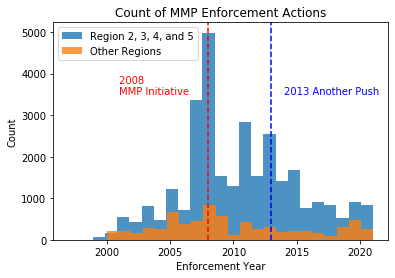

In [53]:
# 2008 MMP initiative
## focusing on Regions 2, 3, 4, and 5

df = matched_trim[(matched_trim.mmp_flag) & (matched_trim.enforced_flag)]
print(df[df.enforcement_year == 2008]['VIOLATED FACILITY REGION'].value_counts())

# count of enforcement actions for mmp violations over time in region 2, 3, 4, and 5
plt.title('Count of MMP Enforcement Actions')
plt.hist(df[df.region_group == 'Region 2, 3, 4, 5'].enforcement_year, bins = len(df.enforcement_year.unique()), alpha = 0.8)
plt.hist(df[df.region_group != 'Region 2, 3, 4, 5'].enforcement_year, bins = len(df.enforcement_year.unique())-3, alpha = 0.8)
plt.legend(['Region 2, 3, 4, and 5', 'Other Regions'])
plt.axvline(x = 2008,color = 'red',linestyle = '--')
plt.annotate('2008 \nMMP Initiative', (2001, 3500), color = 'red')
plt.axvline(x = 2013,color = 'blue',linestyle = '--')
plt.annotate('2013 Another Push', (2014, 3500), color = 'blue')
plt.xlabel('Enforcement Year')
plt.ylabel('Count')
plt.show()

In [54]:
## enforcement agencies in regions 2,3,4,5
## Region 4 divided their cases: some to the State Boards and some for the region themselves
## Region 5 did the initiative themselves
df = matched_trim[(matched_trim.region_group == 'Region 2, 3, 4, 5') & (matched_trim.mmp_flag) & (matched_trim.enforced_flag)]
df = df[df.enforcement_year.isin([2008])]
df.groupby(['VIOLATED FACILITY REGION', 'enforcement_agency'])['enforcement_agency'].count()

VIOLATED FACILITY REGION  enforcement_agency
2                         R2                      67
                          SWB                    106
3                         R3                       4
                          SWB                     31
4                         R4                    1692
                          SWB                     25
5F                        R5                      72
5R                        R5                      71
5S                        R5                    2912
                          nan                      4
Name: enforcement_agency, dtype: int64

> It seems like 2,3 have executed some enforcement orders by themselves and with the help of the state water boards. 

> In region 5, they have executed these enforcement orders themselves.

- [ ] 2013 another push
    - [ ] Region 1 agreed to start themselves but they have very remote and small disadvantaged communities that are often treated differently under the MMP. 
    - [ ] Region 3 finds Mans colony (prison) difficult. It is subject to MMP always. 
    - [ ] Region 7

In [55]:
matched_trim[(matched_trim.region_group == 'Region 1, 7') | (matched_trim['VIOLATED FACILITY REGION'] == 3)]['VIOLATED FACILITY REGION'].value_counts()

1    10047
3     5733
7     3756
Name: VIOLATED FACILITY REGION, dtype: int64

1    2710
3    1717
7    1550
Name: VIOLATED FACILITY REGION, dtype: int64


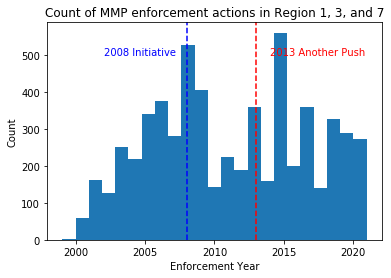

In [56]:
# 2013 push for 1, 3, and 7
## we shouldn't see a big surge because of the complications mentioned by Erin
df = matched_trim[((matched_trim.region_group == 'Region 1, 7') | (matched_trim['VIOLATED FACILITY REGION'] == 3)) & (matched_trim.mmp_flag) & (matched_trim.enforced_flag)]

print(df['VIOLATED FACILITY REGION'].value_counts())

# # count of enforcement actions for mmp violations over time in region 1, 3, 7
# for r in df['VIOLATED FACILITY REGION'].unique().tolist():    
#     sub_df = df[df['VIOLATED FACILITY REGION'] == r]
#     plt.title(f'Count of MMP enforcement actions in Region {r}')
plt.title('Count of MMP enforcement actions in Region 1, 3, and 7')
plt.hist(df.enforcement_year, bins = len(df.enforcement_year.unique()))
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, 500), color = 'blue')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2013 Another Push', (2014, 500), color = 'red')
plt.xlabel('Enforcement Year')
plt.ylabel('Count')
plt.show()

In [57]:
# can we identify facilities serving small communities in Region 1? Check exempt status
df = matched_trim[(matched_trim['VIOLATED FACILITY REGION'].isin([1])) & (matched_trim.mmp_flag)]
df['Enforcement Action'].value_counts()

Admin Civil Liability       2545
Cease and Desist Order       155
Expedited Payment Letter       6
Oral Communication             4
Name: Enforcement Action, dtype: int64

In [59]:
matched[matched['VIOLATED FACILITY REGION'].isin([1])]['Reason Exempt from MMPs'].value_counts()

Compliance with a CDO/TSO issued after 07/01/2000 (13385 (j)(3))                    917
Other                                                                               591
Compliance with a CDO/TSO issued between 01/01/1995-07/01/2000 (13385 (j)(2)(A))     41
No Discharge (13385.1 (a)(2)(A))                                                      1
Name: Reason Exempt from MMPs, dtype: int64

https://leginfo.legislature.ca.gov/faces/codes_displaySection.xhtml?lawCode=WAT&sectionNum=13385:

- 13385 (k)(1): relevant to small communities.
> (k) (1) In lieu of assessing all or a portion of the mandatory minimum penalties pursuant to subdivisions (h) and (i) against a publicly owned treatment works serving a small community, the state board or the regional board may elect to require the publicly owned treatment works to spend an equivalent amount towards the completion of a compliance project proposed by the publicly owned treatment works, if the state board or the regional board finds all of the following:
(A) The compliance project is designed to correct the violations within five years.
(B) The compliance project is in accordance with the enforcement policy of the state board, excluding any provision in the policy that is inconsistent with this section.
(C) The publicly owned treatment works has prepared a financing plan to complete the compliance project.
(2) For the purposes of this subdivision, “a publicly owned treatment works serving a small community” means a publicly owned treatment works serving a population of 20,000 persons or fewer or a rural county, with a financial hardship as determined by the state board after considering such factors as median income of the residents, rate of unemployment, or low population density in the service area of the publicly owned treatment works.

- 13385 (j)(3): 
> (j) Subdivisions (h) and (i) do not apply to any of the following:
(1) A violation caused by one or any combination of the following:
(A) An act of war.
(B) An unanticipated, grave natural disaster or other natural phenomenon of an exceptional, inevitable, and irresistible character, the effects of which could not have been prevented or avoided by the exercise of due care or foresight.
(C) An intentional act of a third party, the effects of which could not have been prevented or avoided by the exercise of due care or foresight.
(D) (i) The operation of a new or reconstructed wastewater treatment unit during a defined period of adjusting or testing, not to exceed 90 days for a wastewater treatment unit that relies on a biological treatment process and not to exceed 30 days for any other wastewater treatment unit, if all of the following requirements are met:
(I) The discharger has submitted to the regional board, at least 30 days in advance of the operation, an operations plan that describes the actions the discharger will take during the period of adjusting and testing, including steps to prevent violations and identifies the shortest reasonable time required for the period of adjusting and testing, not to exceed 90 days for a wastewater treatment unit that relies on a biological treatment process and not to exceed 30 days for any other wastewater treatment unit.
(II) The regional board has not objected in writing to the operations plan.
(III) The discharger demonstrates that the violations resulted from the operation of the new or reconstructed wastewater treatment unit and that the violations could not have reasonably been avoided.
(IV) The discharger demonstrates compliance with the operations plan.
(V) In the case of a reconstructed wastewater treatment unit, the unit relies on a biological treatment process that is required to be out of operation for at least 14 days in order to perform the reconstruction, or the unit is required to be out of operation for at least 14 days and, at the time of the reconstruction, the cost of reconstructing the unit exceeds 50 percent of the cost of replacing the wastewater treatment unit.
(ii) For the purposes of this section, “wastewater treatment unit” means a component of a wastewater treatment plant that performs a designated treatment function.


> We can't quite define small communities given what we currently have. But we can match with social economic data to infer this. We also plan to connect with Erin to get the exact formula for this too. 

## Analysis - Evaluation

### Violations

1. Count of all violations 
2. Count of violations by type: effluent, reporting, MMP serious, MMP chronic, MMP reporting, non-MMP 
3. Ratio of violations that are MMP


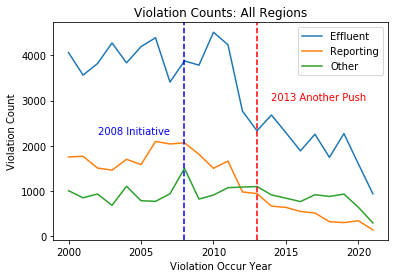

In [60]:
# count of effluent, reporting, and other violations
df = matched_trim.groupby(['violation_year', 'violation_category'])['FACILITY_ID'].count().to_frame().reset_index()

plt.title('Violation Counts: All Regions')
plt.xlabel('Violation Occur Year')
plt.ylabel('Violation Count')
plt.plot(df[df.violation_category == 'Effluent'].violation_year, df[df.violation_category == 'Effluent'].FACILITY_ID)
plt.plot(df[df.violation_category == 'Reporting'].violation_year, df[df.violation_category == 'Reporting'].FACILITY_ID)
plt.plot(df[df.violation_category == 'Other'].violation_year, df[df.violation_category == 'Other'].FACILITY_ID)
plt.legend(['Effluent', 'Reporting', 'Other'])
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, max(df.FACILITY_ID)/2), color = 'blue')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2013 Another Push', (2014, max(df.FACILITY_ID)/1.5), color = 'red')

plt.show()

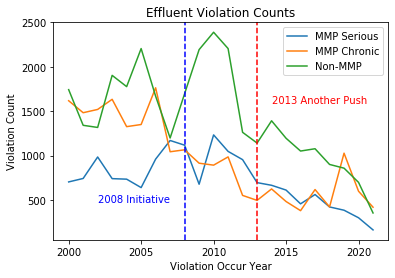

In [61]:
# count of mmp serious, mmp chronic, and non-mmp for effluent violations
df = matched_trim[matched_trim['VIOLATION TYPE'] == 'Effluent'].groupby(['violation_year', 'MMP TYPE'])['FACILITY_ID'].count().to_frame().reset_index()

plt.title('Effluent Violation Counts')
plt.xlabel('Violation Occur Year')
plt.ylabel('Violation Count')
plt.plot(df[df['MMP TYPE'] == 'Serious'].violation_year, df[df['MMP TYPE'] == 'Serious'].FACILITY_ID)
plt.plot(df[df['MMP TYPE'] == 'Chronic'].violation_year, df[df['MMP TYPE'] == 'Chronic'].FACILITY_ID)
plt.plot(df[df['MMP TYPE'] == 'Non-MMP'].violation_year, df[df['MMP TYPE'] == 'Non-MMP'].FACILITY_ID)
plt.legend(['MMP Serious', 'MMP Chronic', 'Non-MMP'])
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, max(df.FACILITY_ID)/5), color = 'blue')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2013 Another Push', (2014, max(df.FACILITY_ID)/1.5), color = 'red')

plt.show()

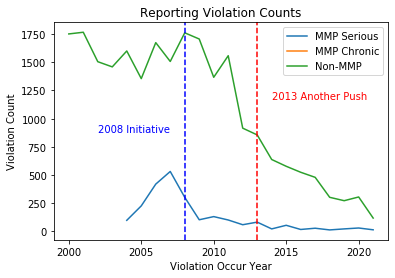

In [62]:
# count of mmp serious, mmp chronic, and non-mmp for reporting violations
df = matched_trim[matched_trim['VIOLATION TYPE'] == 'Reporting'].groupby(['violation_year', 'MMP TYPE'])['FACILITY_ID'].count().to_frame().reset_index()

plt.title('Reporting Violation Counts')
plt.xlabel('Violation Occur Year')
plt.ylabel('Violation Count')
plt.plot(df[df['MMP TYPE'] == 'Serious'].violation_year, df[df['MMP TYPE'] == 'Serious'].FACILITY_ID)
plt.plot(df[df['MMP TYPE'] == 'Chronic'].violation_year, df[df['MMP TYPE'] == 'Chronic'].FACILITY_ID)
plt.plot(df[df['MMP TYPE'] == 'Non-MMP'].violation_year, df[df['MMP TYPE'] == 'Non-MMP'].FACILITY_ID)
plt.legend(['MMP Serious', 'MMP Chronic', 'Non-MMP'])
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, max(df.FACILITY_ID)/2), color = 'blue')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2013 Another Push', (2014, max(df.FACILITY_ID)/1.5), color = 'red')

plt.show()

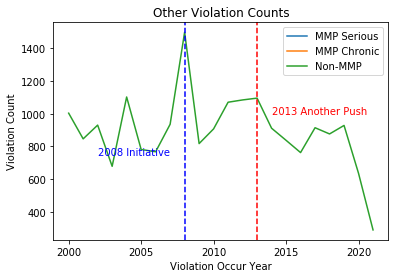

In [63]:
# count of mmp serious, mmp chronic, and non-mmp for other violations
df = matched_trim[matched_trim['violation_category'] == 'Other'].groupby(['violation_year', 'MMP TYPE'])['FACILITY_ID'].count().to_frame().reset_index()

plt.title('Other Violation Counts')
plt.xlabel('Violation Occur Year')
plt.ylabel('Violation Count')
plt.plot(df[df['MMP TYPE'] == 'Serious'].violation_year, df[df['MMP TYPE'] == 'Serious'].FACILITY_ID)
plt.plot(df[df['MMP TYPE'] == 'Chronic'].violation_year, df[df['MMP TYPE'] == 'Chronic'].FACILITY_ID)
plt.plot(df[df['MMP TYPE'] == 'Non-MMP'].violation_year, df[df['MMP TYPE'] == 'Non-MMP'].FACILITY_ID)
plt.legend(['MMP Serious', 'MMP Chronic', 'Non-MMP'])
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, max(df.FACILITY_ID)/2), color = 'blue')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2013 Another Push', (2014, max(df.FACILITY_ID)/1.5), color = 'red')

plt.show()

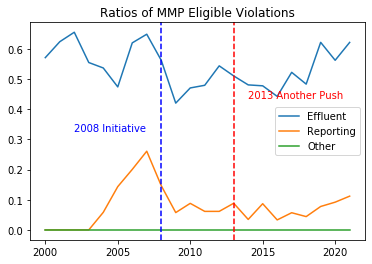

In [64]:
# ratios of violations that are eligible for MMP
df = matched_trim.groupby(['violation_year','violation_category', 'mmp_flag'])['FACILITY_ID'].count().to_frame().reset_index().pivot_table(index = ['violation_year', 'violation_category'], columns = 'mmp_flag', values = 'FACILITY_ID').reset_index()
df = df.rename(columns = {False: 'Non-MMP', True: 'MMP'})
df['Non-MMP'] = df['Non-MMP'].fillna(0)
df['MMP'] = df['MMP'].fillna(0)
df['total'] = df['Non-MMP'] + df['MMP']
df['mmp_rate'] = df['MMP']/df['total']

plt.title('Ratios of MMP Eligible Violations')
plt.plot(df[df['violation_category'] == 'Effluent'].violation_year, df[df['violation_category'] == 'Effluent'].mmp_rate)
plt.plot(df[df['violation_category'] == 'Reporting'].violation_year, df[df['violation_category'] == 'Reporting'].mmp_rate)
plt.plot(df[df['violation_category'] == 'Other'].violation_year, df[df['violation_category'] == 'Other'].mmp_rate)
plt.legend(['Effluent', 'Reporting', 'Other'])
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, max(df.mmp_rate)/2), color = 'blue')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2013 Another Push', (2014, max(df.mmp_rate)/1.5), color = 'red')

plt.show()

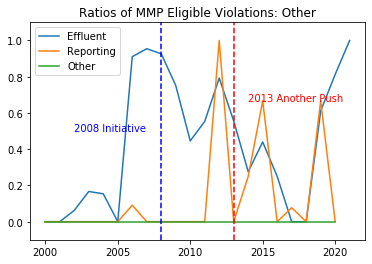

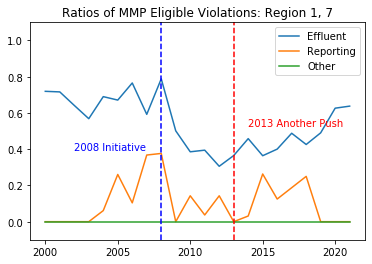

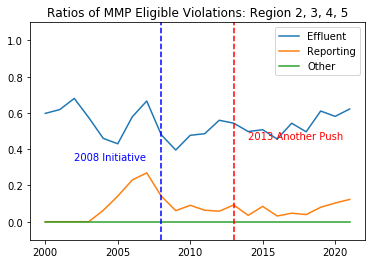

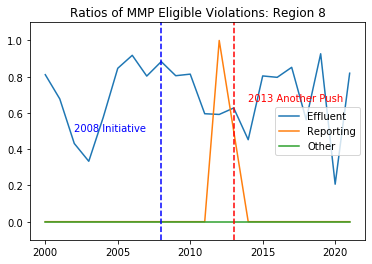

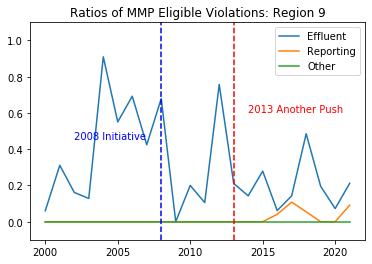

In [65]:
# by region groups
df = matched_trim.groupby(['region_group', 'violation_year','violation_category', 'mmp_flag'])['FACILITY_ID'].count().to_frame().reset_index().pivot_table(index = ['region_group', 'violation_year', 'violation_category'], columns = 'mmp_flag', values = 'FACILITY_ID').reset_index()
df = df.rename(columns = {False: 'Non-MMP', True: 'MMP'})
df['Non-MMP'] = df['Non-MMP'].fillna(0)
df['MMP'] = df['MMP'].fillna(0)
df['total'] = df['Non-MMP'] + df['MMP']
df['mmp_rate'] = df['MMP']/df['total']

r_groups = df.region_group.unique()
for r in r_groups:
    sub_df = df[df.region_group == r]
    
    plt.title(f'Ratios of MMP Eligible Violations: {r}')
    plt.plot(sub_df[sub_df['violation_category'] == 'Effluent'].violation_year, sub_df[sub_df['violation_category'] == 'Effluent'].mmp_rate)
    plt.plot(sub_df[sub_df['violation_category'] == 'Reporting'].violation_year, sub_df[sub_df['violation_category'] == 'Reporting'].mmp_rate)
    plt.plot(sub_df[sub_df['violation_category'] == 'Other'].violation_year, sub_df[sub_df['violation_category'] == 'Other'].mmp_rate)
    plt.legend(['Effluent', 'Reporting', 'Other'])
    plt.axvline(x = 2008, color = 'blue', linestyle = '--')
    plt.annotate('2008 Initiative', (2002, max(sub_df.mmp_rate)/2), color = 'blue')
    plt.axvline(x = 2013,color = 'red',linestyle = '--')
    plt.annotate('2013 Another Push', (2014, max(sub_df.mmp_rate)/1.5), color = 'red')
    plt.ylim(-0.1,1.1)

    plt.show()

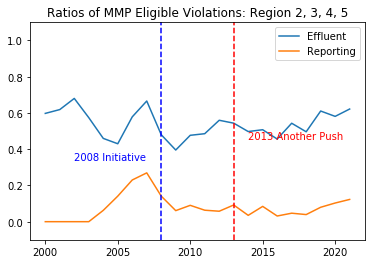

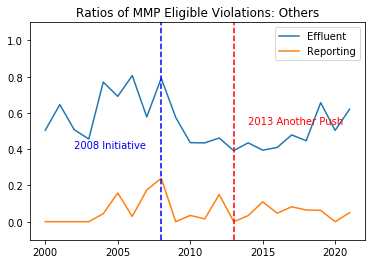

In [66]:
# compare Regions 2,3,4,5 vs others
r = 'Region 2, 3, 4, 5'

sub_df = df[df.region_group == r]

plt.title(f'Ratios of MMP Eligible Violations: {r}')
plt.plot(sub_df[sub_df['violation_category'] == 'Effluent'].violation_year, sub_df[sub_df['violation_category'] == 'Effluent'].mmp_rate)
plt.plot(sub_df[sub_df['violation_category'] == 'Reporting'].violation_year, sub_df[sub_df['violation_category'] == 'Reporting'].mmp_rate)
plt.legend(['Effluent', 'Reporting'])
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, max(sub_df.mmp_rate)/2), color = 'blue')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2013 Another Push', (2014, max(sub_df.mmp_rate)/1.5), color = 'red')
plt.ylim(-0.1,1.1)
plt.show()

sub_df = df[df.region_group != r]
sub_df = sub_df.groupby(['violation_year', 'violation_category'])['MMP', 'total'].sum().reset_index()
sub_df['mmp_rate'] = sub_df['MMP']/sub_df.total

plt.title('Ratios of MMP Eligible Violations: Others')
plt.plot(sub_df[sub_df['violation_category'] == 'Effluent'].violation_year, sub_df[sub_df['violation_category'] == 'Effluent'].mmp_rate)
plt.plot(sub_df[sub_df['violation_category'] == 'Reporting'].violation_year, sub_df[sub_df['violation_category'] == 'Reporting'].mmp_rate)
plt.legend(['Effluent', 'Reporting'])
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, max(sub_df.mmp_rate)/2), color = 'blue')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2013 Another Push', (2014, max(sub_df.mmp_rate)/1.5), color = 'red')
plt.ylim(-0.1,1.1)
plt.show()

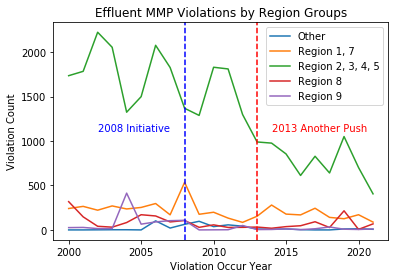

In [67]:
sub_df = df[df.violation_category == 'Effluent']
r_groups = sub_df.region_group.unique()
for r in r_groups:
    plt.plot(sub_df[sub_df.region_group == r].violation_year, sub_df[sub_df.region_group == r].MMP)

plt.title('Effluent MMP Violations by Region Groups')
plt.xlabel('Violation Occur Year')
plt.ylabel('Violation Count')
plt.legend(r_groups)
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, max(sub_df.MMP)/2), color = 'blue')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2013 Another Push', (2014, max(sub_df.MMP)/2), color = 'red')
plt.show()

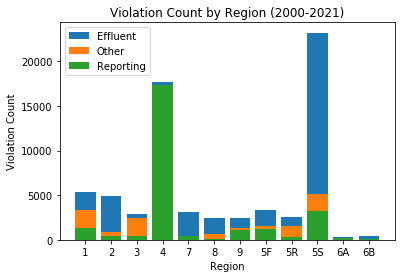

In [68]:
# which region has the most violations? 
df = matched_trim.groupby(['VIOLATED FACILITY REGION', 'violation_category'])['FACILITY_ID'].count().to_frame().reset_index()
v_type = df.violation_category.unique()
for t in v_type:
    sub_df = df[df.violation_category == t]
    plt.bar(sub_df['VIOLATED FACILITY REGION'].astype('str'), sub_df.FACILITY_ID)
plt.legend(v_type)
plt.title('Violation Count by Region (2000-2021)')
plt.xlabel('Region')
plt.ylabel('Violation Count')
plt.show()

> Region 4 and 5 have the most violations. Region 4 has more reporting violations and Region 5 has more effluent violations.

In [69]:
# which type of facilities has the most violations? 
matched_trim.groupby(['violation_category','PLACE SUBTYPE'])['FACILITY_ID'].count().sort_values(ascending = False)

violation_category  PLACE SUBTYPE                
Effluent            Wastewater Treatment Facility    45976
Other               Wastewater Treatment Facility    12573
Reporting           Wastewater Treatment Facility     5079
                    Domestic Site NEC                 2829
                    Service/Commercial Site, NEC      2515
                                                     ...  
Other               Waste Pile                           1
                    Composting Facility                  1
Effluent            Surface Impoundment                  1
                    Land Treatment Unit                  1
Reporting           Composting Facility                  0
Name: FACILITY_ID, Length: 136, dtype: int64

In [70]:
matched_trim.groupby(['violation_category', 'PROGRAM'])['FACILITY_ID'].count().sort_values(ascending = False)

violation_category  PROGRAM       
Effluent            NPDMUNILRG        28495
                    NPDMUNIOTH        18055
Reporting           NPDNONMUNIPRCS    16879
Effluent            NPDNONMUNIPRCS    12021
Other               NPDMUNILRG         8431
                                      ...  
Reporting           AGT                   1
                    LNDISP                1
                    UST                   1
Effluent            AGT                   1
Reporting           WDR                   0
Name: FACILITY_ID, Length: 68, dtype: int64

> Wastewater Treatment Facilities have the most violations across all violation types.

### Enforcements 

1. Count of different enforcement types for different violation types 
2. Enforcement rates for different violation types within 6, 12, 18, 24 months, and ever of the occurance of violations.
3. Average years violation to enforcement for different violation types

In [71]:
# did mmp mostly result in ACL? formal enforcement? informal?
matched_trim[matched_trim.mmp_flag]['Enforcement Action'].value_counts()

Admin Civil Liability           32343
Settlement - Court Order         3722
Expedited Payment Letter          662
Cease and Desist Order            377
Notice of Violation               186
Time Schedule Order                95
Clean-up and Abatement Order       23
13267 Letter                       13
Oral Communication                  7
Staff Enforcement Letter            6
Formal Refer to Attorney Gen        5
Notice to Comply                    4
Stipulated Penalty                  1
Name: Enforcement Action, dtype: int64

In [72]:
sum(matched_trim[matched_trim.mmp_flag]['Enforcement Action'].isin(['Admin Civil Liability', 'Settlement - Court Order', 'Expedited Payment Letter']))/sum(matched_trim.mmp_flag)

0.9302213666987488

In [124]:
sum(matched_trim[matched_trim.mmp_flag]['Enforcement Action'] == 'Admin Civil Liability')/sum(matched_trim.mmp_flag)

0.8191834253583912

In [73]:
sum(matched_trim[~matched_trim.mmp_flag]['Enforcement Action'].isin(['Admin Civil Liability', 'Settlement - Court Order', 'Expedited Payment Letter']))/sum(~matched_trim.mmp_flag)

0.11906268121672202

> MMP violations often result (93% of the time) in ACL, settlement in court, and expedited payment letter, which are all formal enforcement actions.

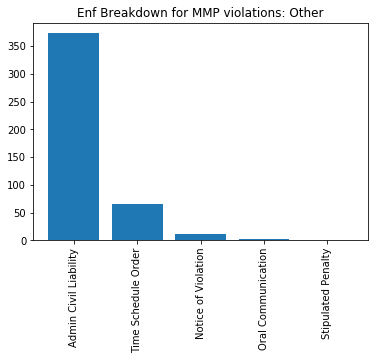

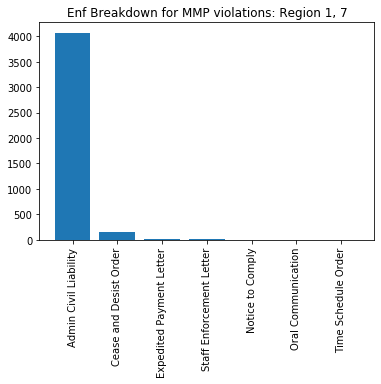

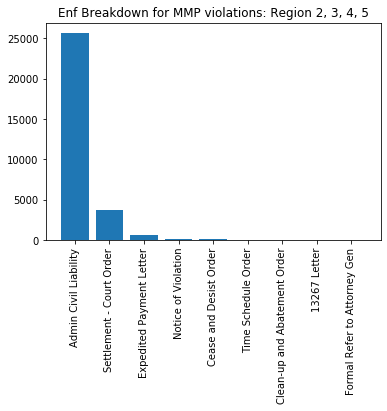

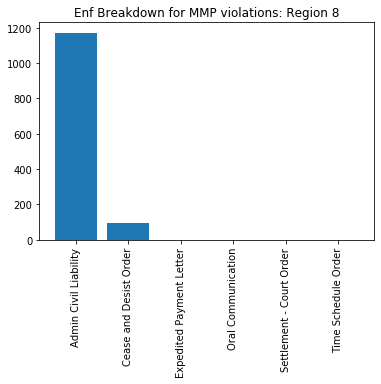

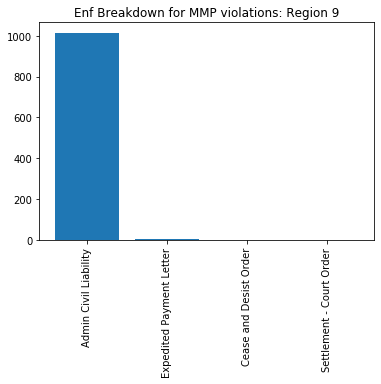

In [74]:
# what is the breakdown of enforcement actions for MMP violations across regions? 
df = matched_trim[matched_trim.mmp_flag].groupby(['region_group', 'Enforcement Action'])['FACILITY_ID'].count().to_frame().reset_index().sort_values(by = ['region_group', 'FACILITY_ID'], ascending = False)
for r in r_groups:
    sub_df = df[df.region_group == r]
    plt.title(f"Enf Breakdown for MMP violations: {r}")
    plt.bar(sub_df['Enforcement Action'], sub_df.FACILITY_ID)
    plt.xticks(rotation = 90)
    plt.show()

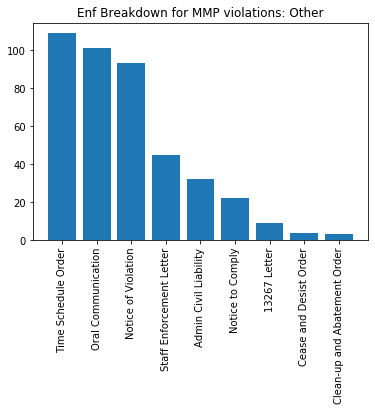

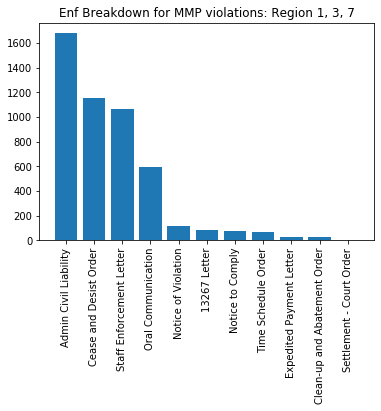

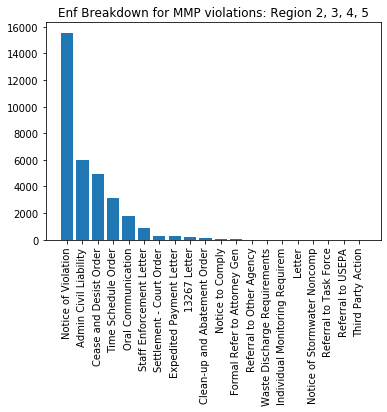

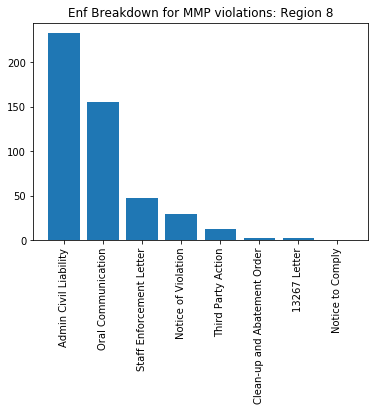

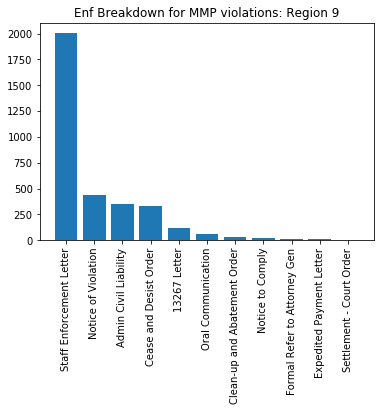

In [50]:
# what is the breakdown of enforcement actions for non-MMP violations across regions? 
df = matched_trim[~matched_trim.mmp_flag].groupby(['region_group', 'Enforcement Action'])['FACILITY_ID'].count().to_frame().reset_index().sort_values(by = ['region_group', 'FACILITY_ID'], ascending = False)
for r in r_groups:
    sub_df = df[df.region_group == r]
    plt.title(f"Enf Breakdown for MMP violations: {r}")
    plt.bar(sub_df['Enforcement Action'], sub_df.FACILITY_ID)
    plt.xticks(rotation = 90)
    plt.show()

In [75]:
def plot_enf_rate(region_group, violation_type, enf_day):
    """
    a general funciton to plot enforcement rates for different violation types within different timeframe
    """
    if (region_group == 'all') & (violation_type == 'all'):
        df = matched_trim
    elif (region_group == 'all') & (violation_type != 'all'):
        df = matched_trim[matched_trim.violation_category == violation_type]
    elif (region_group != 'all') & (violation_type == 'all'):
        df = matched_trim[matched_trim.region_group == region_group]
    else:
        df = matched_trim[(matched_trim.region_group == region_group) & (matched_trim.violation_category == violation_type)]
    
    df['enforced_within_period'] =  df.viol_to_enf_time < pd.Timedelta(enf_day, 'D')

    viol_count = df.groupby(['violation_year','mmp_flag'])['FACILITY_ID'].count().to_frame().reset_index()
    viol_count = viol_count.pivot_table(index = 'violation_year', columns = 'mmp_flag', values = 'FACILITY_ID').reset_index()
    viol_count = viol_count.rename(columns = {False: 'Non-MMP_viol', True: 'MMP_viol'})

    enf_count = df.groupby(['violation_year','mmp_flag','enforced_within_period'])['FACILITY_ID'].count().to_frame().reset_index()
    enf_count = enf_count[enf_count.enforced_within_period].pivot_table(index = 'violation_year', columns = 'mmp_flag', values = 'FACILITY_ID').reset_index()
    enf_count = enf_count.rename(columns = {False: 'Non-MMP_enf', True: 'MMP_enf'})
    enf_count['Non-MMP_enf'] = enf_count['Non-MMP_enf'].fillna(0)
    enf_count['MMP_enf'] = enf_count['MMP_enf'].fillna(0)

    enf_rate = pd.merge(viol_count, enf_count)
    enf_rate['Non-MMP'] = enf_rate['Non-MMP_enf']/enf_rate['Non-MMP_viol']
    enf_rate['MMP'] = enf_rate['MMP_enf']/enf_rate['MMP_viol']

    plt.title(f'Enfor Rates Within {int(enf_day/30)} Months: {region_group}')
    plt.plot(enf_rate.violation_year, enf_rate['MMP'])
    plt.plot(enf_rate.violation_year, enf_rate['Non-MMP'])
    plt.xlabel('Violation Occur Year')
    plt.ylabel('Enforcement Rate')
    plt.ylim(-0.1,1.1)
    plt.legend(['MMP', 'Non-MMP'])
    plt.axvline(x = 2008, color = 'blue', linestyle = '--')
    plt.annotate('2008 Initiative', (2002, 0.3), color = 'blue')
    plt.axvline(x = 2013,color = 'red',linestyle = '--')
    plt.annotate('2013 Another Push', (2014, 0.3), color = 'red')
    plt.show()

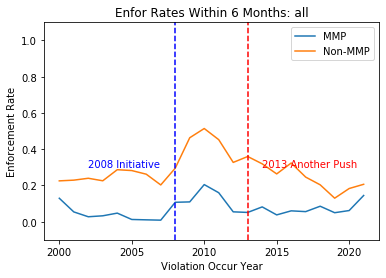

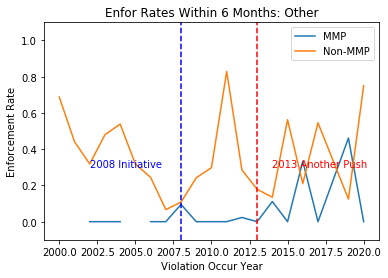

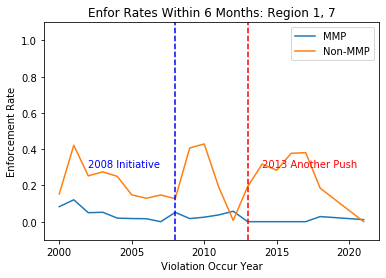

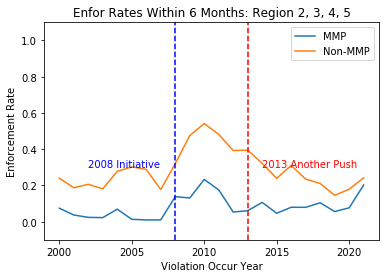

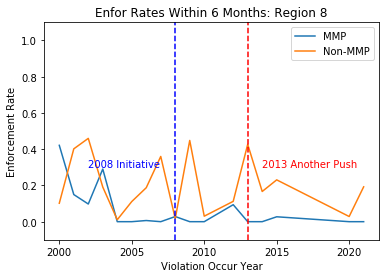

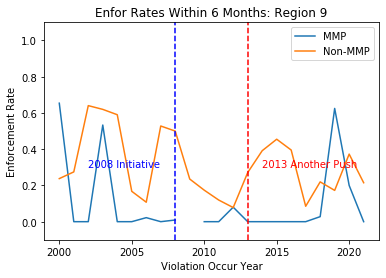

In [76]:
# violations 6 months
plot_enf_rate('all', 'all', 30*6)
for r in r_groups:
    plot_enf_rate(r, 'all', 30*6)

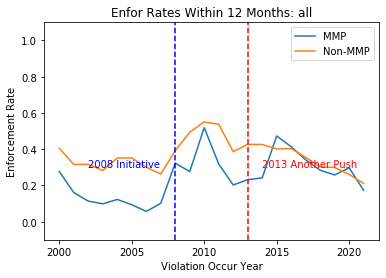

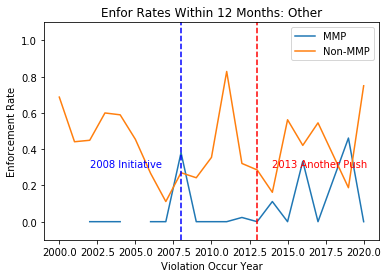

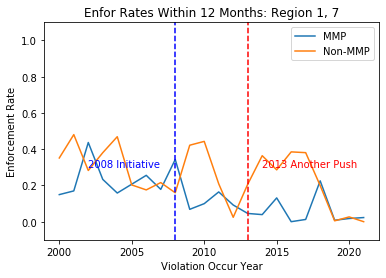

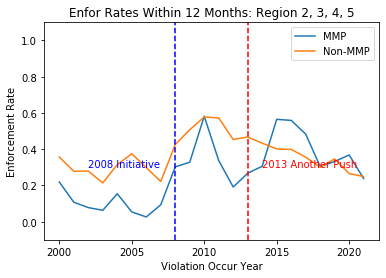

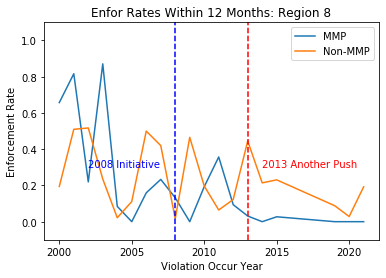

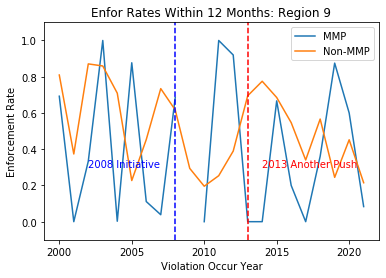

In [77]:
# effluent violations 12 months
plot_enf_rate('all', 'all', 30*12)
for r in r_groups:
    plot_enf_rate(r, 'all', 30*12)

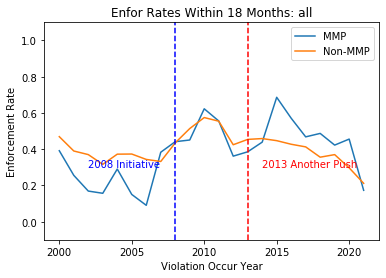

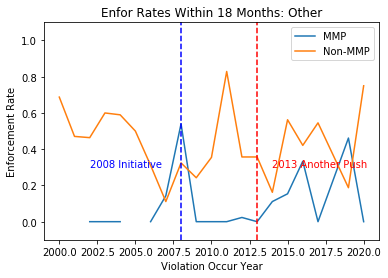

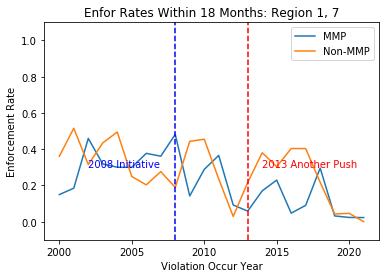

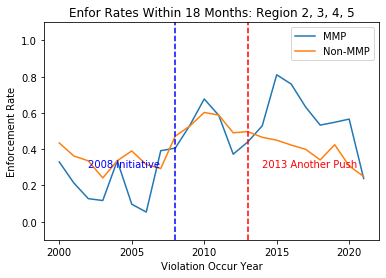

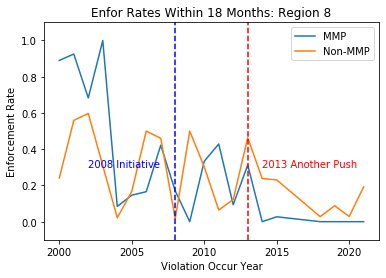

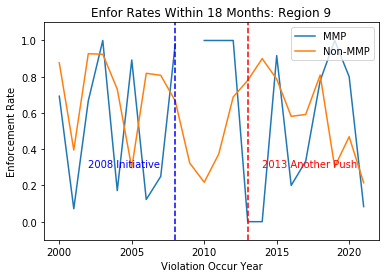

In [78]:
# effluent violations 18 months
plot_enf_rate('all', 'all', 30*18)
for r in r_groups:
    plot_enf_rate(r, 'all', 30*18)

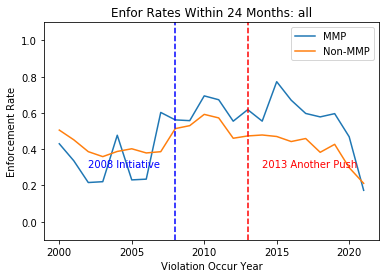

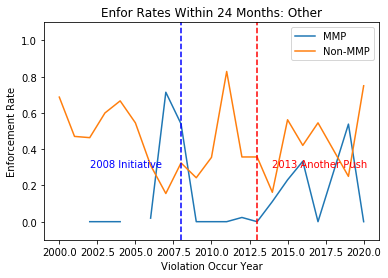

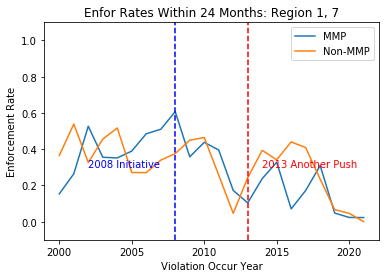

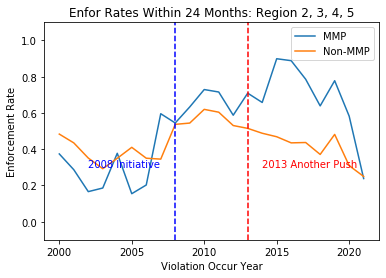

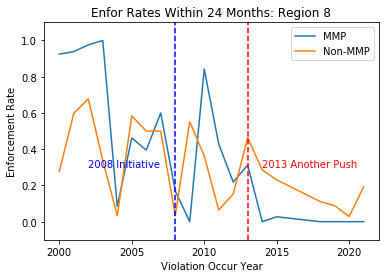

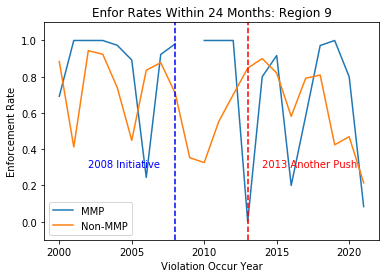

In [79]:
# violations 24 months
plot_enf_rate('all', 'all', 30*24)
for r in r_groups:
    plot_enf_rate(r, 'all', 30*24)

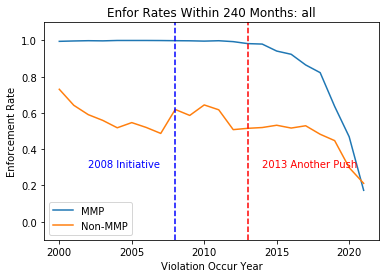

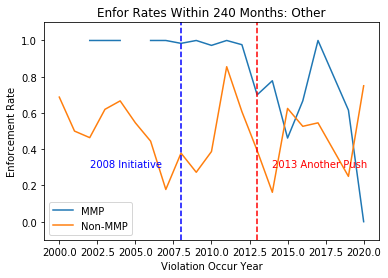

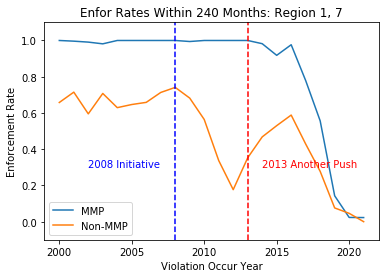

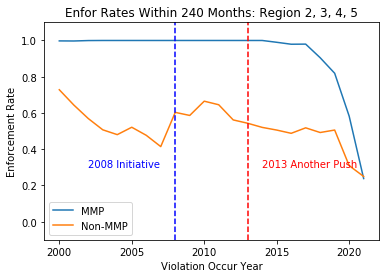

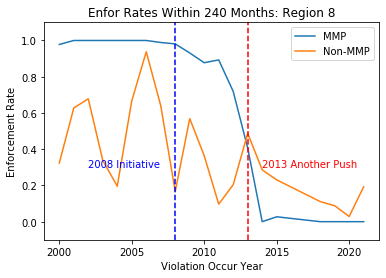

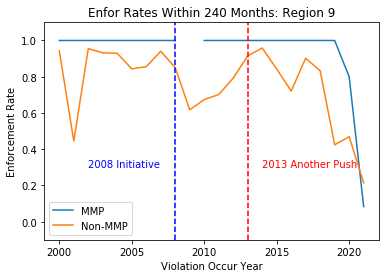

In [80]:
# violations ever
plot_enf_rate('all', 'all', 30*240)
for r in r_groups:
    plot_enf_rate(r, 'all', 30*240)

In [81]:
# average years to enforcement actions after a violation occurs
matched_trim['days_to_enf'] = matched_trim.viol_to_enf_time / np.timedelta64(1, 'D')
# for each enforcement order, choose the violation record that occurred the earliest
matched_trim_grouped = matched_trim.sort_values(['EA Order Number', 'OCCURRED ON']).groupby(['EA Order Number', 'EA Effective Date']).head(1)
sum(matched_trim_grouped.days_to_enf < 0)/len(matched_trim_grouped)

0.033750958834057786

> about 3% of enforcement orders appear before the earliest violation record assoicated with it. This is likely a data error. We will remove them from the analysis 

In [82]:
remove_enf = matched_trim_grouped[matched_trim_grouped.days_to_enf < 0]['EA Order Number'].unique()
len(remove_enf)

119

In [83]:
matched_trim_grouped = matched_trim_grouped[~(matched_trim_grouped.days_to_enf < 0)]

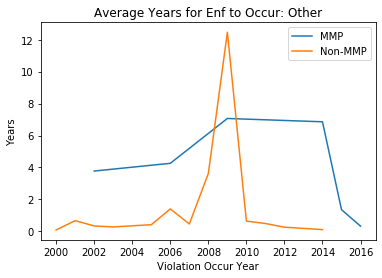

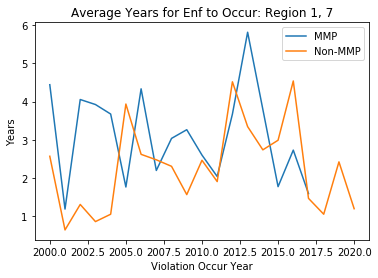

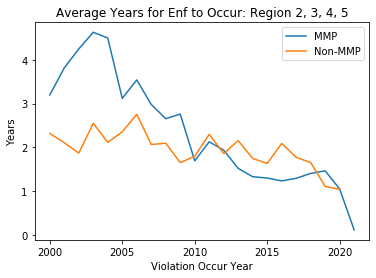

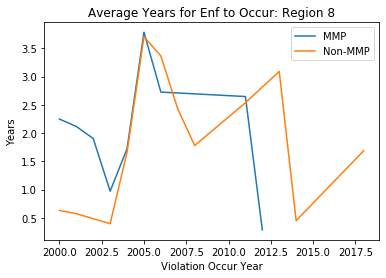

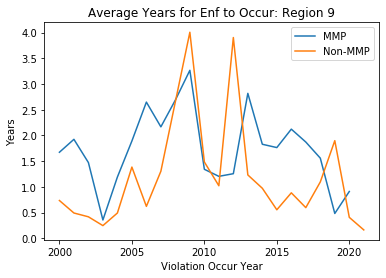

In [84]:
enf_time = matched_trim_grouped.groupby(['region_group', 'violation_year', 'mmp_flag'])['days_to_enf'].mean().to_frame().reset_index()
enf_time['years_to_enf'] = enf_time.days_to_enf/365

for r in r_groups:
    sub_df = enf_time[enf_time.region_group == r]
    plt.title(f'Average Years for Enf to Occur: {r}')
    plt.plot(sub_df[sub_df.mmp_flag].violation_year, sub_df[sub_df.mmp_flag].years_to_enf)
    plt.plot(sub_df[~sub_df.mmp_flag].violation_year, sub_df[~sub_df.mmp_flag].years_to_enf)
    plt.xlabel('Violation Occur Year')
    plt.ylabel('Years')
    plt.legend(['MMP', 'Non-MMP'])
    plt.show()

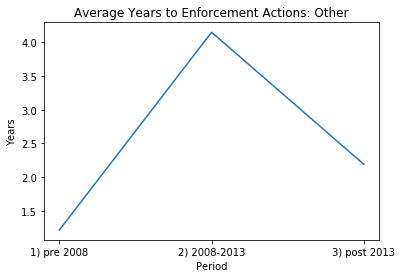

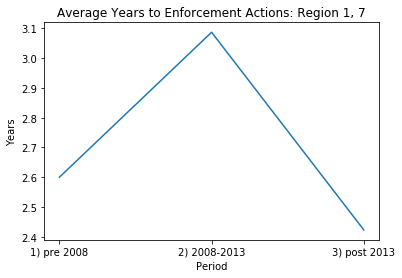

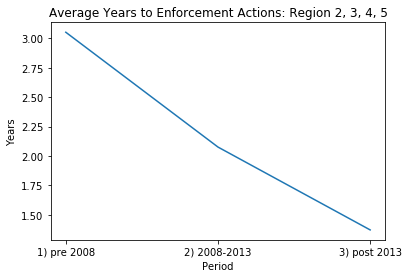

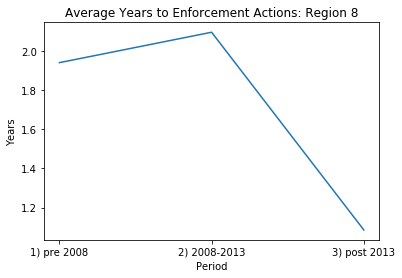

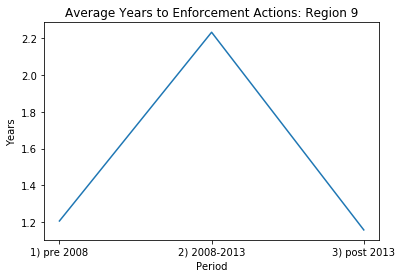

In [85]:
# group period into before 2008, 2008 - 2013, and after 2013
enf_time['period'] = ['1) pre 2008' if y < 2008 else '2) 2008-2013' if (y>=2007) & (y<=2013) else '3) post 2013' for y in enf_time.violation_year]
enf_time_grouped = enf_time.groupby(['region_group', 'period'])['days_to_enf'].mean().to_frame().reset_index()
regions = enf_time_grouped['region_group'].unique()
for r in regions:
    sub_df = enf_time_grouped[enf_time_grouped['region_group'] == r]
    plt.title(f"Average Years to Enforcement Actions: {r}")
    plt.plot(sub_df.period, sub_df.days_to_enf/360)
    plt.xlabel('Period')
    plt.ylabel('Years')
    plt.show()

In [86]:
enf_time_grouped['years_to_enf'] = enf_time_grouped.days_to_enf/360
enf_time_grouped.pivot(index = 'region_group', columns = 'period', values = 'years_to_enf')

period,1) pre 2008,2) 2008-2013,3) post 2013
region_group,,,
Other,1.218932,4.148434,2.191667
"Region 1, 7",2.600172,3.086868,2.423159
"Region 2, 3, 4, 5",3.052521,2.075680,1.370738
Region 8,1.941437,2.097037,1.085417
Region 9,1.205791,2.232828,1.157262


In [126]:
enf_time_grouped['years_to_enf'].mean()

2.1258628090306373

> On average, it takes about two years for an enforcement action to occur after the date of violaitons.

> We do see a drop of average days it takes for Effluent MMP vilations to result in enforcement actions over the pre-2007, 2007-2013, and post-2013 period across regions. The time is likely an overstatement because the enforcement records show the last stage of enforcement actions. 

> Region 9 has been consistently enforcing MMP penalties. While region 1, 4, and 5 show the most imporvement over time.

### Active Permit Counts

Active: start date is within or before the year and end date is either after or within the year or null or the status shows active

In [88]:
years = range(2000, 2022, 1)
counts = []
for y in years:
    y_start = dt.datetime(y, 1, 1)
    y_end = dt.datetime(y, 12, 30)
    sc_period['active_flag'] = (sc_period.start_date <= y_end) & ((sc_period.end_date >= y_start) | (pd.isnull(sc_period.end_date)) | (sc_period.Status == 'Active'))
    df = sc_period.groupby(['Region'])['active_flag'].sum().to_frame().reset_index()
    df = df.rename(columns = {'active_flag': 'permit_count'})
    df['year'] = y
    df = df[['year', 'Region', 'permit_count']]
    counts.append(df)
permit_count = pd.concat(counts)
permit_count.head()

,year,Region,permit_count
0,2000,1,59.0
1,2000,2,344.0
2,2000,3,86.0
3,2000,4,925.0
4,2000,5F,72.0


In [89]:
# compare 2021 
permit_count[permit_count.year == 2008].sort_values('permit_count', ascending = False)

,year,Region,permit_count
3,2008,4,1414.0
10,2008,8,606.0
1,2008,2,461.0
6,2008,5S,318.0
11,2008,9,207.0
2,2008,3,193.0
5,2008,5R,143.0
0,2008,1,71.0
4,2008,5F,67.0
9,2008,7,47.0


> Region 4 has the most NPDES permits. Then Region 5 combined. What are the facility breakdown in these regions? 

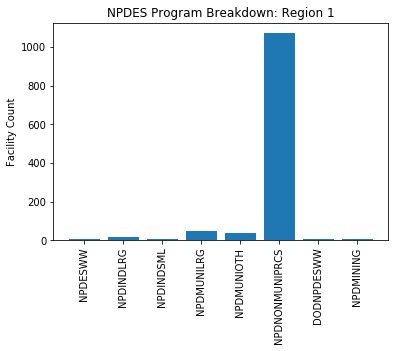

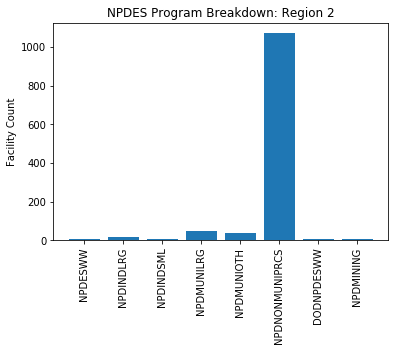

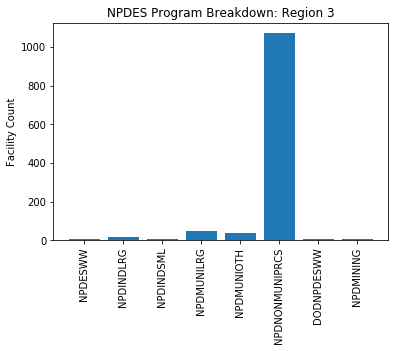

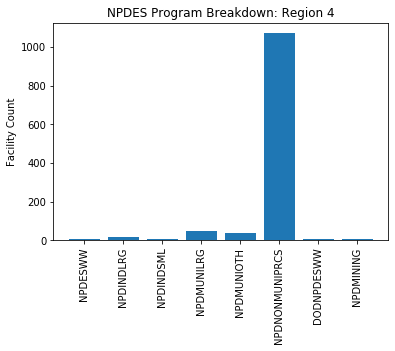

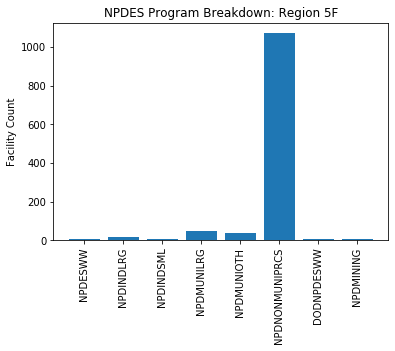

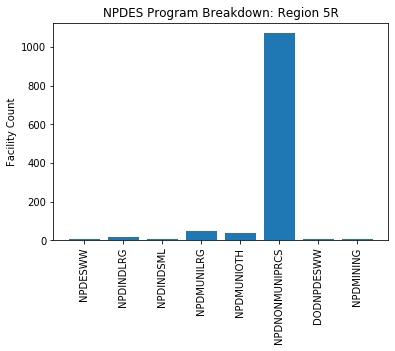

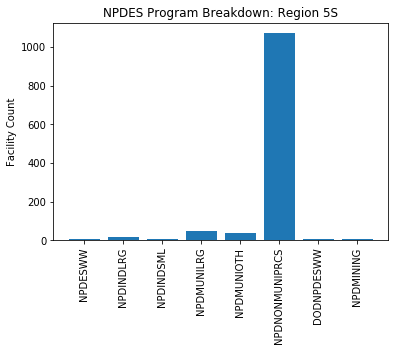

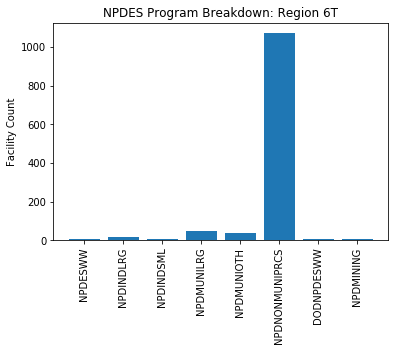

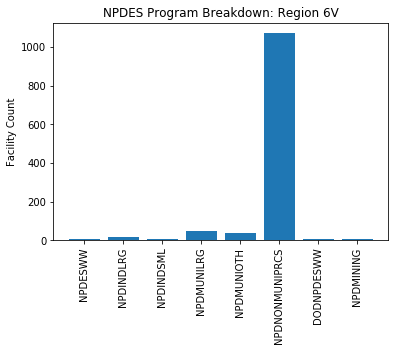

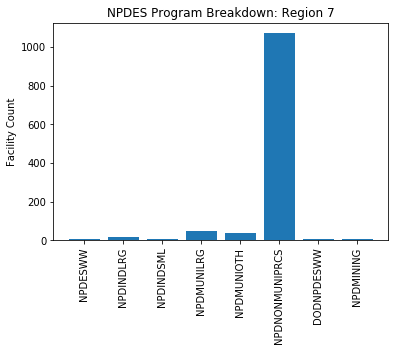

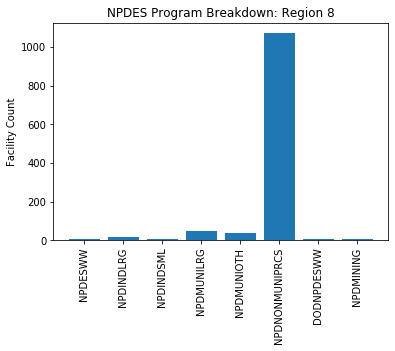

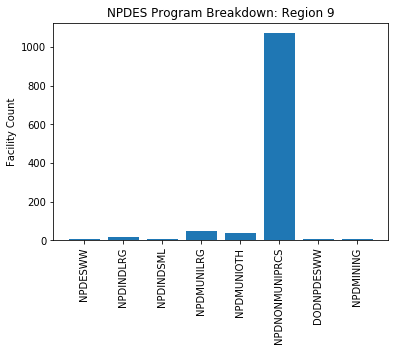

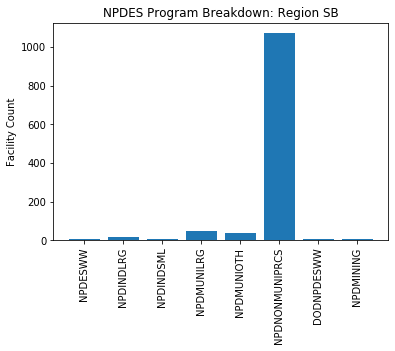

In [90]:
df = sc_period[sc_period.active_flag].groupby(['Region', 'Program'])['WDID'].count().to_frame().reset_index()
for r in df.Region.unique():
    plt.title(f'NPDES Program Breakdown: Region {r}')
    plt.bar(df.Program, df.WDID)
    plt.xticks(rotation = 90)
    plt.ylabel('Facility Count')
    plt.show()

> NPDES program breakdown is similar across regions, with non-municipal private companies being the majority of facilities. 

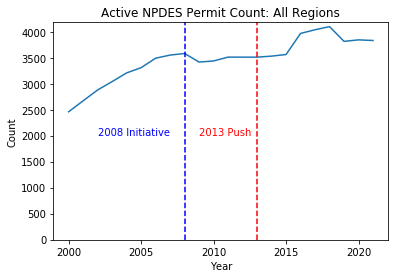

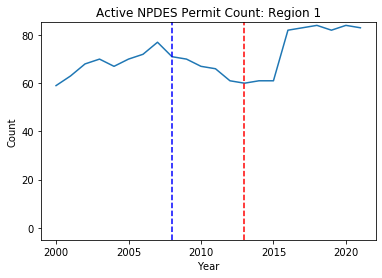

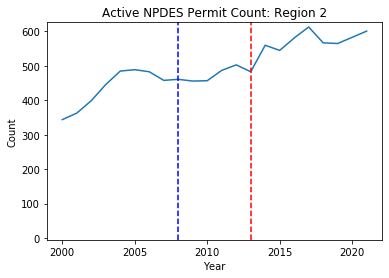

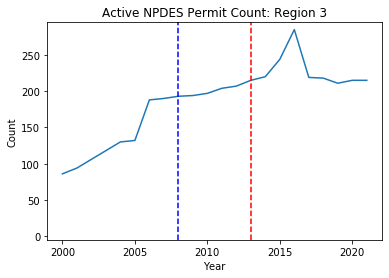

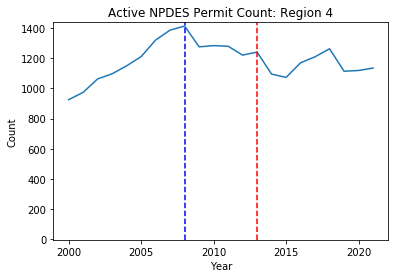

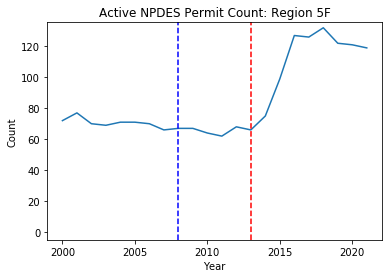

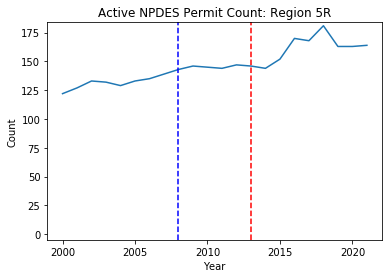

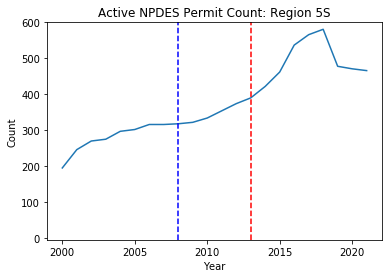

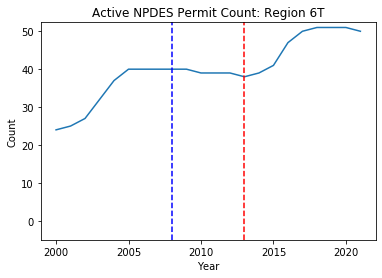

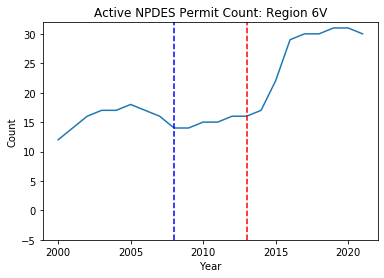

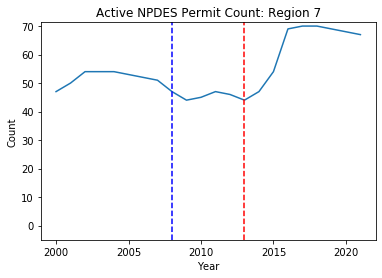

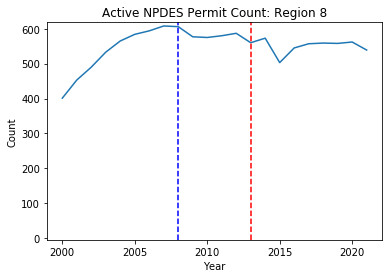

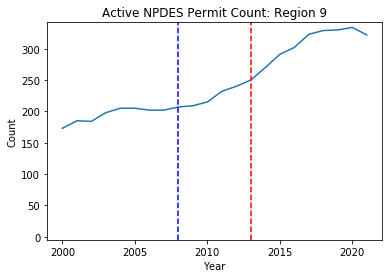

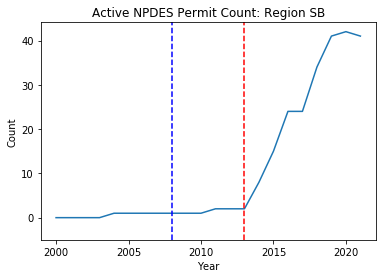

In [91]:
# plot trends over time 
plt.title('Active NPDES Permit Count: All Regions')
all_count = permit_count.groupby(['year'])['permit_count'].sum().to_frame().reset_index()
plt.plot(all_count.year, all_count.permit_count)
plt.xlabel('Year')
plt.ylabel('Count')
plt.ylim(-5)
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, 2000), color = 'blue')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2013 Push', (2009, 2000), color = 'red')
plt.show()

# by regions
regions = permit_count.Region.unique()
for r in regions:
    sub_df = permit_count[permit_count.Region == r]
    plt.title(f'Active NPDES Permit Count: Region {r}')
    plt.plot(sub_df.year, sub_df.permit_count)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.ylim(-5)
    plt.axvline(x = 2008, color = 'blue', linestyle = '--')
    plt.axvline(x = 2013,color = 'red',linestyle = '--')
    plt.show()

> The number of active permits across time seems pretty stable, except around 2015. What happened around then? Note that the database transfer to CIWQS was in 2005. 

> The number of permits dropped noticably in region 1 and 4 around 2007. Investigate what permits dropped out:

In [92]:
df = sc_period[sc_period.Region == '4']

y = 2008
y_start = dt.datetime(y, 1, 1)
y_end = dt.datetime(y, 12, 30)
df['active_flag_2008'] = (df.start_date <= y_end) & ((df.end_date >= y_start) | (pd.isnull(df.end_date)) | (df.Status == 'Active'))

y = 2009
y_start = dt.datetime(y, 1, 1)
y_end = dt.datetime(y, 12, 30)
df['active_flag_2009'] = (df.start_date <= y_end) & ((df.end_date >= y_start) | (pd.isnull(df.end_date)) | (df.Status == 'Active'))

sum(df.active_flag_2008 & ~df.active_flag_2009)

180

In [93]:
df[df.active_flag_2008 & ~df.active_flag_2009].Program.value_counts()

NPDNONMUNIPRCS    168
NPDESWW            10
NPDMUNILRG          1
NPDINDSML           1
Name: Program, dtype: int64

In [94]:
df_permits = df[df.active_flag_2008 & ~df.active_flag_2009]['WDID'].tolist()
facility_scrapped[facility_scrapped.WDID.isin(df_permits)].groupby(['WDID'])['Status'].count().sort_values()

WDID
4A196000636    1
4B197500053    1
4B197500055    1
4B197500057    1
4B197500060    1
              ..
4B192575001    3
4B192129002    4
4B192124001    4
4A560117001    5
4B190106061    5
Name: Status, Length: 180, dtype: int64

In [95]:
facility_scrapped[facility_scrapped.WDID == '4B192129002']

,Unnamed: 0,Reg Measure ID,Reg Measure Type,Region,Program,Order No.,WDID,Effective Date,Expiration Date,Status,Amended?
55353,0,132170,NPDES Permit,4,NPDESWW,R4-2003-0117,4B192129002,09/11/2003,08/10/2008,Historical,N
55354,0,136121,NPDES Permit,4,NPDESWW,97-004,4B192129002,01/27/1997,12/10/2001,Historical,N
55355,0,134776,NPDES Permit,4,NPDESWW,91-067,4B192129002,06/03/1991,05/10/1996,Historical,N
55356,0,133991,NPDES Permit,4,NPDESWW,84-063,4B192129002,06/25/1984,05/10/1989,Historical,N


> There is no obvious signal of permits changing to a different program from the scrapped table. A potential pathway would be to check facilities that shift out of NPDES programs. The key question is how many facilities shift out of the NPDES programs around the time of MMP initiatives?

#### Facilities shifting out of NPDES programs

In [96]:
df = facility_scraped[~facility_scraped['Effective Date'].isna()].groupby(['WDID', 'npdes_flag'])['Program'].count().to_frame().reset_index().groupby(['WDID'])['npdes_flag'].count().sort_values().to_frame().reset_index()
df_change = facility_scraped[~facility_scraped['Effective Date'].isna()][facility_scraped.WDID.isin(df[df.npdes_flag > 1].WDID)]
print(f'{len(df_change.WDID.unique())} facilities have changes in NPDES programs.')

df_change = df_change.sort_values(['WDID', 'Effective Date'])
df_change['npdes_int'] = [1 if n else 0 for n in df_change.npdes_flag]
df_change['npdes_diff'] = df_change.npdes_int.diff()
mask = df_change.WDID != df_change.WDID.shift(1)
df_change['npdes_diff'][mask] = np.nan
df_change['npdes_out_flag'] = df_change.npdes_diff == -1
df_change[df_change.npdes_out_flag].WDID

269 facilities have changes in NPDES programs.


9308     1A80077OTRI
50647    1A84002OSIS
11798     1A84006ODN
9261      1A89001NDN
61829    1B02002NSON
            ...     
27801    9 000000175
37337    9 000000275
44618    9 000000732
44633    9 000000900
58504    9 000001503
Name: WDID, Length: 255, dtype: object

In [97]:
facility_scraped = facility_scraped.sort_values(['WDID', 'Effective Date'])
facility_scraped[facility_scraped.WDID == '9 000001503']

,Unnamed: 0,Reg Measure ID,Reg Measure Type,Region,Program,Order No.,WDID,Effective Date,Expiration Date,Status,Amended?,npdes_flag
58505,0,321390,NPDES Permit,9,NPDNONMUNIPRCS,R9-2007-0006,9 000001503,2007-03-01,2012-03-01,Historical,N,True
58504,0,389306,Waiver,9,ANIWSTOTH,R9-2013-0005,9 000001503,2013-02-13,NaT,Active,N,False
58503,0,397053,Enrollee - Waiver,9,ANIWSTOTH,R9-2019-0005W7,9 000001503,2014-07-24,2024-05-08,Active,N,False
58502,0,383582,13267 Letter (Non-Enforcement),9,WDR,R9-2012-0034,9 000001503,NaT,NaT,Never Active,N,False


In [99]:
npdes_out = df_change[df_change.npdes_out_flag]
npdes_out['year'] = [d.year for d in npdes_out['Effective Date']]

print(f'{len(npdes_out.WDID.unique())} permits changed from NPDES program to a non-NPDES program at some point.')
npdes_out.groupby(['Region', 'Program', 'year'])['WDID'].count().sort_values(ascending = False)

245 permits changed from NPDES program to a non-NPDES program at some point.


Region  Program      year
SB      SLIC         2020    131
5R      ANIWSTOTH    2010      7
                     2004      4
4       PTPRG        2006      4
1       ANIWSTOTH    2017      2
                            ... 
5S      ANIWSTOTH    2007      1
        DODWDR       2004      1
        INDSTW       2005      1
        WDRINDIVLRG  2019      1
1       ANIWSTOTH    2014      1
Name: WDID, Length: 105, dtype: int64

> Most of the changes are the SLIC programs initiated by the state water boards in 2020. SLIC Sites are Spills, Leaks, Investigation, and Cleanup sites, where chemical releases have contaminated soil and/or groundwater. There might be a push for SLIC program in 2020. There is not a strong signal of facilities changing out of NPDES programs in the regions of interest around the MMP intiatives. https://www.homeservicesnhd.com/resources/homeservicesnhd-envweb.pdf

In [100]:
# look into specific examples in region 4
npdes_out[npdes_out.Region == '4']

,Unnamed: 0,Reg Measure ID,Reg Measure Type,Region,Program,Order No.,WDID,Effective Date,Expiration Date,Status,Amended?,npdes_flag,npdes_int,npdes_diff,npdes_out_flag,year
35472,0,307134,Letter,4,PTPRG,Letter,4A560104001,2006-07-25,NaT,Historical,N,False,0,-1.0,True,2006
35572,0,307132,Letter,4,PTPRG,Letter,4A560105001,2006-07-17,NaT,Historical,N,False,0,-1.0,True,2006
46867,0,307131,Letter,4,PTPRG,Letter,4A560108001,2006-07-25,NaT,Historical,N,False,0,-1.0,True,2006
47177,0,307130,Letter,4,PTPRG,Letter,4A560110001,2006-07-25,NaT,Historical,N,False,0,-1.0,True,2006
47385,0,319251,NPDES Permit,4,ANIWSTOTH,R4-2007-0004,4A565022002,2007-03-02,2011-12-10,Historical,Y,False,0,-1.0,True,2007
63828,0,376408,Letter,4,WDRNONMUNIPRCS,2004-0009-DWQ,4A567900009,2010-09-07,NaT,Historical,N,False,0,-1.0,True,2010
18943,0,312608,NPDES Permit,4,ANIWSTOTH,R4-2006-0061,4B190144001,2006-07-13,2011-06-10,Historical,N,False,0,-1.0,True,2006
12536,0,319252,NPDES Permit,4,ANIWSTOTH,R4-2007-0005,4B191309001,2007-03-02,2011-12-10,Historical,N,False,0,-1.0,True,2007


#### Breakdown of facility type

In [101]:
sc_period.Program.value_counts()

NPDNONMUNIPRCS    5516
NPDESWW            747
NPDMUNILRG         230
NPDMUNIOTH         196
NPDINDSML          110
NPDINDLRG           74
DODNPDESWW          48
NPDMINING           42
DODNPDESSW           3
Name: Program, dtype: int64

In [102]:
npdes_viol['PROGRAM'].value_counts()

NPDMUNILRG        39674
NPDNONMUNIPRCS    31218
NPDMUNIOTH        24139
NPDESWW            7212
NPDINDLRG          4516
NPDINDSML          2245
NPDMINING          1644
DODNPDESWW         1471
Name: PROGRAM, dtype: int64

In [103]:
39674/len(npdes_viol)

0.35385617067579983

In [104]:
df = npdes_viol.groupby(['PROGRAM', 'PLACE SUBTYPE'])['FACILITY_ID'].count().to_frame().reset_index()
df[df.PROGRAM == 'NPDMUNILRG'].sort_values('FACILITY_ID', ascending = False)

,PROGRAM,PLACE SUBTYPE,FACILITY_ID
84,NPDMUNILRG,Wastewater Treatment Facility,38725
81,NPDMUNILRG,Pulp and Paper,255
76,NPDMUNILRG,Collection_System,235
85,NPDMUNILRG,Water Treatment Plant,92
83,NPDMUNILRG,Utility Structure,11
78,NPDMUNILRG,Manufacturing NEC,10
79,NPDMUNILRG,Metal Mining,8
80,NPDMUNILRG,Power Plant,8
82,NPDMUNILRG,Recycled Water Use Area,7
77,NPDMUNILRG,Domestic Site NEC,1


> Facilities in program NPDMUNILARG (likely NPDES municipal large facilities) have the largest number of effluent violations. Most of them are wastewater treatment facility. Check count of these facilities.

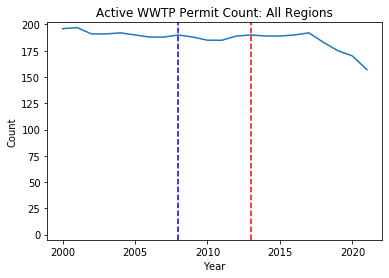

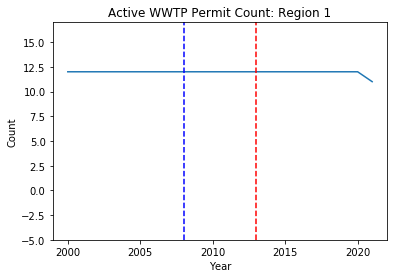

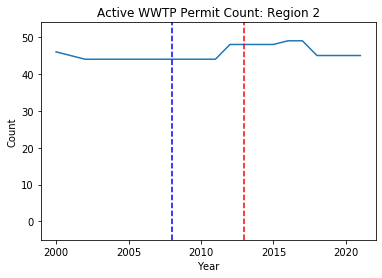

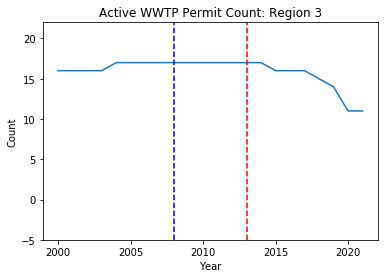

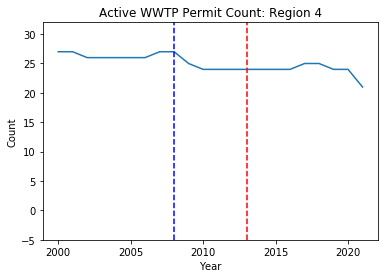

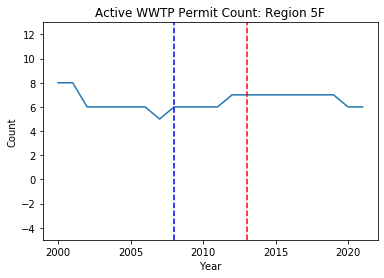

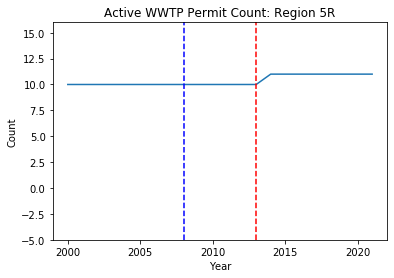

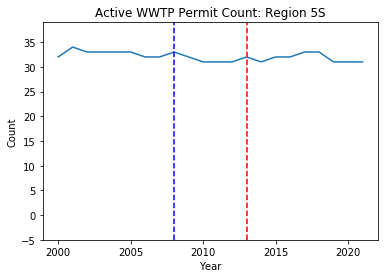

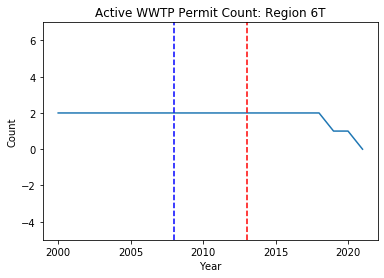

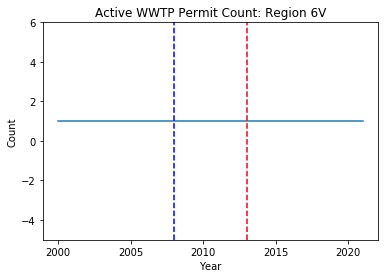

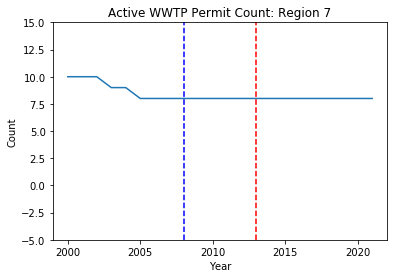

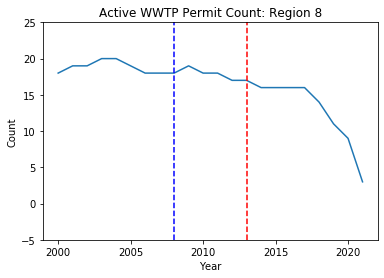

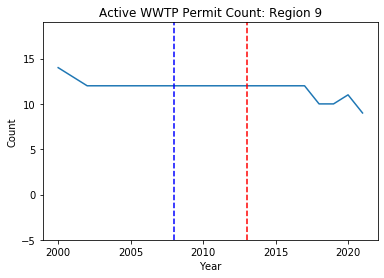

In [105]:
wwtp = sc_period[sc_period.Program == 'NPDMUNILRG']

years = range(2000, 2022, 1)
counts = []
for y in years:
    y_start = dt.datetime(y, 1, 1)
    y_end = dt.datetime(y, 12, 30)
    wwtp['active_flag'] = (wwtp.start_date <= y_end) & ((wwtp.end_date >= y_start) | (pd.isnull(wwtp.end_date)))
    df = wwtp.groupby(['Region'])['active_flag'].sum().to_frame().reset_index()
    df = df.rename(columns = {'active_flag': 'permit_count'})
    df['year'] = y
    df = df[['year', 'Region', 'permit_count']]
    counts.append(df)
wwtp_count = pd.concat(counts)

# plot trends over time 
plt.title('Active WWTP Permit Count: All Regions')
all_count = wwtp_count.groupby(['year'])['permit_count'].sum().to_frame().reset_index()
plt.plot(all_count.year, all_count.permit_count)
plt.xlabel('Year')
plt.ylabel('Count')
plt.ylim(-5, max(all_count.permit_count)+5)
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.show()

# by regions
regions = wwtp_count.Region.unique()
for r in regions:
    sub_df = wwtp_count[wwtp_count.Region == r]
    plt.title(f'Active WWTP Permit Count: Region {r}')
    plt.plot(sub_df.year, sub_df.permit_count)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.ylim(-5, max(sub_df.permit_count)+5)
    plt.axvline(x = 2008, color = 'blue', linestyle = '--')
    plt.axvline(x = 2013,color = 'red',linestyle = '--')
    plt.show()

> The number of WWTP remains pretty consisten across regions. There are not many of them. 

## Analysis - Violation Rates

1. proportion of facilities that have a least one MMP violation, effluent MMP violation, reporting MMP violation, non-MMP violation. 
2. proportion of facilities with a descreasing number of MMP violation, effluent MMP violation, reporting MMP violation, non-MMP violation.

Overall then by region groups.

In [106]:
viol_count = npdes_viol.groupby(['region_group', 'WDID_x', 'violation_year', 'violation_category', 'mmp_flag', 'enforced_flag'])['VIOLATION ID (VID)'].count().to_frame().reset_index()
viol_count = viol_count.rename(columns = {'VIOLATION ID (VID)': 'violation_count'})
viol_count

,region_group,WDID_x,violation_year,violation_category,mmp_flag,enforced_flag,violation_count
0,Other,2 386065001,2010,Other,False,False,1
1,Other,2 386065001,2012,Effluent,False,False,1
2,Other,2 386065001,2012,Other,False,False,1
3,Other,3 400107001,2006,Other,False,False,14
4,Other,3 440102001,2005,Other,False,False,1
...,...,...,...,...,...,...,...
20317,Region 9,9 000003166,2018,Reporting,False,True,1
20318,Region 9,9 000003166,2019,Reporting,False,True,1
20319,Region 9,9 000003206,2017,Reporting,False,True,1
20320,Region 9,9 000003206,2018,Reporting,False,True,4


### Overall violation rates

In [107]:
def plot_overall_violation_rates(viol_count_df, viol_count_threshold, permit_count_df, permit_type):
    # overall violation rate
    viol_count_df = viol_count_df[viol_count_df.violation_count >= viol_count_threshold]
    viol_count_all = viol_count_df.groupby(['violation_year', 'WDID_x'])['violation_count'].sum().to_frame().reset_index().groupby(['violation_year'])['WDID_x'].count().to_frame().reset_index()
    viol_count_all = viol_count_all.rename(columns = {'WDID_x': 'violator_count'})

    permit_count_all = permit_count_df.groupby(['year'])['permit_count'].sum().to_frame().reset_index()
    permit_count_all = permit_count_all.rename(columns = {'year': 'violation_year'})

    viol_rate_all = pd.merge(permit_count_all, viol_count_all, how = 'left')
    viol_rate_all['violation_rate'] = viol_rate_all.violator_count/viol_rate_all.permit_count

    # overall MMP effluent violation rate
    viol_count_mmp_eff = viol_count_df[(viol_count_df.mmp_flag) & (viol_count_df.violation_category == 'Effluent')].groupby(['violation_year', 'WDID_x'])['violation_count'].sum().to_frame().reset_index().groupby(['violation_year'])['WDID_x'].count().to_frame().reset_index()
    viol_count_mmp_eff = viol_count_mmp_eff.rename(columns = {'WDID_x': 'violator_count'})

    viol_rate_mmp_eff = pd.merge(permit_count_all, viol_count_mmp_eff, how = 'left')
    viol_rate_mmp_eff['violation_rate'] = viol_rate_mmp_eff.violator_count/viol_rate_mmp_eff.permit_count

    # overall MMP reporting violation rate
    viol_count_mmp_rep = viol_count_df[(viol_count_df.mmp_flag) & (viol_count_df.violation_category == 'Reporting')].groupby(['violation_year', 'WDID_x'])['violation_count'].sum().to_frame().reset_index().groupby(['violation_year'])['WDID_x'].count().to_frame().reset_index()
    viol_count_mmp_rep = viol_count_mmp_rep.rename(columns = {'WDID_x': 'violator_count'})

    viol_rate_mmp_rep = pd.merge(permit_count_all, viol_count_mmp_rep, how = 'left')
    viol_rate_mmp_rep['violation_rate'] = viol_rate_mmp_rep.violator_count/viol_rate_mmp_rep.permit_count

    # overall non-MMP violation rate
    viol_count_non_mmp = viol_count_df[~viol_count_df.mmp_flag].groupby(['violation_year', 'WDID_x'])['violation_count'].sum().to_frame().reset_index().groupby(['violation_year'])['WDID_x'].count().to_frame().reset_index()
    viol_count_non_mmp = viol_count_non_mmp.rename(columns = {'WDID_x': 'violator_count'})

    viol_rate_non_mmp = pd.merge(permit_count_all, viol_count_non_mmp, how = 'left')
    viol_rate_non_mmp['violation_rate'] = viol_rate_non_mmp.violator_count/viol_rate_non_mmp.permit_count

    # plot rates
    plt.title(f'Proportion of active {permit_type} permits with at least {viol_count_threshold} violation')
    plt.plot(viol_rate_all.violation_year, viol_rate_all.violation_rate, linewidth = 3)
    plt.plot(viol_rate_mmp_eff.violation_year, viol_rate_mmp_eff.violation_rate)
    plt.plot(viol_rate_mmp_rep.violation_year, viol_rate_mmp_rep.violation_rate)
    plt.plot(viol_rate_non_mmp.violation_year, viol_rate_non_mmp.violation_rate)
    plt.legend(['All Violations', 'MMP Effluent', 'MMP Reporting', 'Non-MMP'], loc = (1.01, 0.05))
    plt.xlabel('Violation Occur Year')
    plt.ylabel('Violation Rate')
    #plt.ylim(0, 0.8)
    plt.axvline(x = 2008, color = 'blue', linestyle = '--')
    plt.axvline(x = 2013,color = 'red',linestyle = '--')
    plt.annotate('2008 Initiative', (2002, 0.1), color = 'blue')
    plt.annotate('2013 Push', (2009, 0.1), color = 'red')
    plt.show()

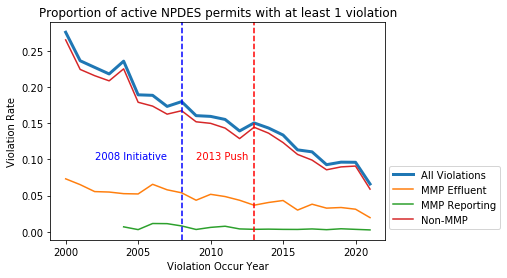

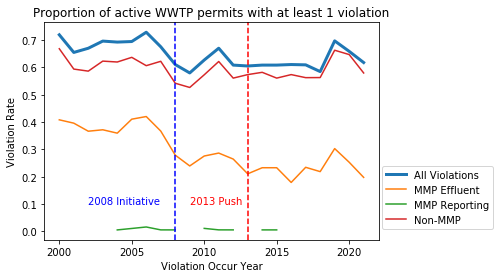

In [108]:
# all active NPDES permits
plot_overall_violation_rates(viol_count_df = viol_count, viol_count_threshold = 1, permit_count_df = permit_count, permit_type = 'NPDES')
# all active WWTP permits
viol_count_wwtp = npdes_viol[npdes_viol.PROGRAM == 'NPDMUNILRG'].groupby(['region_group', 'WDID_x', 'violation_year', 'violation_category', 'mmp_flag', 'enforced_flag'])['VIOLATION ID (VID)'].count().to_frame().reset_index()
viol_count_wwtp = viol_count_wwtp.rename(columns = {'VIOLATION ID (VID)': 'violation_count'})
plot_overall_violation_rates(viol_count_df = viol_count_wwtp, viol_count_threshold = 1, permit_count_df = wwtp_count, permit_type = 'WWTP')

count    20322.000000
mean         5.479923
std         18.992616
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        923.000000
Name: violation_count, dtype: float64


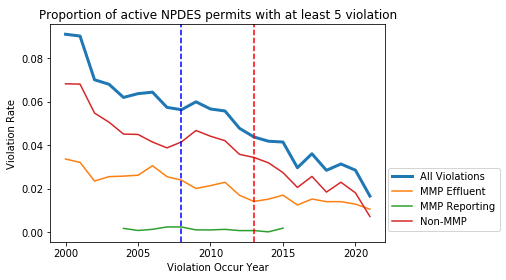

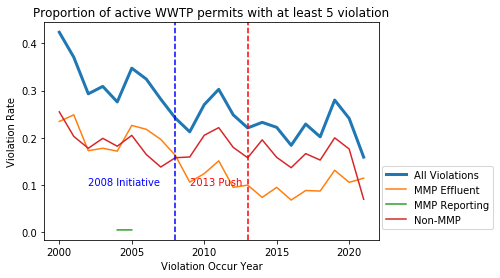

In [109]:
# test a different violation count threshold: the mean of the violation counts
print(viol_count.violation_count.describe())
t = int(viol_count.violation_count.mean())
plot_overall_violation_rates(viol_count_df = viol_count, viol_count_threshold = t, permit_count_df = permit_count, permit_type = 'NPDES')
plot_overall_violation_rates(viol_count_df = viol_count_wwtp, viol_count_threshold = t, permit_count_df = wwtp_count, permit_type = 'WWTP')

> there is a suggestive signal of reducing MMP effluent violation rates among WWTP permits. We will focus on WWTP permits in the following analysis.

#### WWTP Basics

In [914]:
# counts of wwtp in history
len(wwtp)

230

In [917]:
# counts of wwtp by regions in history
wwtp.groupby(['Region'])['WDID'].count().sort_values()

Region
6V     1
6T     2
5F    10
5R    11
7     11
1     13
9     15
3     17
8     25
4     31
5S    42
2     52
Name: WDID, dtype: int64

In [919]:
wwtp['region_group'] = ['Region 2, 3, 4, 5' if r in ['2', '3', '4', '5S', '5R', '5F'] else 'Other' for r in wwtp.Region]
wwtp.groupby(['region_group'])['WDID'].count().sort_values()

region_group
Other                 67
Region 2, 3, 4, 5    163
Name: WDID, dtype: int64

In [1018]:
# counts of currently active wwtp
sum(wwtp.active_flag)

157

In [1019]:
wwtp[wwtp.active_flag].groupby(['Region'])['WDID'].count().sort_values()

Region
6V     1
8      3
5F     6
7      8
9      9
1     11
3     11
5R    11
4     21
5S    31
2     45
Name: WDID, dtype: int64

In [1020]:
wwtp[wwtp.active_flag].groupby(['region_group'])['WDID'].count().sort_values()

region_group
Other                 32
Region 2, 3, 4, 5    125
Name: WDID, dtype: int64

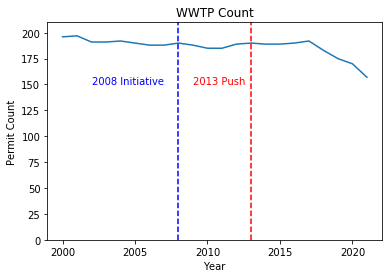

In [1392]:
# count of WWTPs in graph
df = wwtp_count.groupby(['year'])['permit_count'].sum().to_frame().reset_index()
plt.title('WWTP Count')
plt.plot(df.year, df.permit_count)
plt.ylim(0, 210)
plt.xlabel('Year')
plt.ylabel('Permit Count')
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2008 Initiative', (2002, 150), color = 'blue')
plt.annotate('2013 Push', (2009, 150), color = 'red')
plt.show()

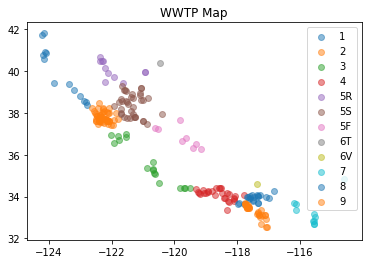

In [984]:
# locations of WWTP: urban or rural? where violations are more prevalent?
df = pd.merge(wwtp, facility[['WDID', 'Longitude', 'Latitude']], how = 'left')
df = df.drop_duplicates()
df.Latitude = df.Latitude.astype('float')
df.Longitude = df.Longitude.astype('float')
plt.title('WWTP Map')
for r in df.Region.unique():
    sub_df = df[df.Region ==r]
    plt.scatter(sub_df.Longitude, sub_df.Latitude, alpha = 0.5)
plt.legend(df.Region.unique())
plt.show()

In [1016]:
# active age for WWTP
wwtp['end_date'] = wwtp.end_date.fillna(dt.date.today())
wwtp['end_date'] = pd.to_datetime(wwtp.end_date)
wwtp['active_days'] = wwtp.end_date - wwtp.start_date
wwtp['active_days'] = wwtp.active_days/np.timedelta64(1, 'D')
wwtp['active_years'] = wwtp.active_days/365
wwtp.active_years.describe()

count    230.000000
mean      33.123836
std       13.428277
min        0.263014
25%       25.185616
50%       39.342466
75%       41.281507
max       62.287671
Name: active_years, dtype: float64

In [1022]:
# active age for other permits
non_wwtp = sc_period[sc_period.Program != 'NPDMUNILRG']
non_wwtp['end_date'] = non_wwtp.end_date.fillna(dt.date.today())
non_wwtp['end_date'] = pd.to_datetime(non_wwtp.end_date)
non_wwtp['active_days'] = non_wwtp.end_date - non_wwtp.start_date
non_wwtp['active_days'] = non_wwtp.active_days/np.timedelta64(1, 'D')
non_wwtp['active_years'] = non_wwtp.active_days/365
non_wwtp.active_years.describe()

count    6736.000000
mean       12.768771
std        10.171329
min         0.002740
25%         4.295890
50%         9.991781
75%        21.030137
max        55.950685
Name: active_years, dtype: float64

> WWTP is active much longer than other permits

#### WWTP MMP Violation Enforcements

In [1393]:
# enforcement rates for WWTP vs other permits
matched_trim['wwtp_flag'] = matched_trim.PROGRAM == 'NPDMUNILRG'

def plot_enf_rate_wwtp(violation_type):
    """
    a general funciton to plot enforcement rates for WWTP permits and other permits
    """
    df = matched_trim[matched_trim.mmp_flag]
    if violation_type != 'all':
        df = df[df.violation_category == violation_type]

    viol_count = df.groupby(['violation_year','wwtp_flag'])['FACILITY_ID'].count().to_frame().reset_index()
    viol_count = viol_count.pivot_table(index = 'violation_year', columns = 'wwtp_flag', values = 'FACILITY_ID').reset_index()
    viol_count = viol_count.rename(columns = {False: 'Non-WWTP_viol', True: 'WWTP_viol'})

    enf_count = df.groupby(['violation_year','wwtp_flag', 'enforced_flag'])['FACILITY_ID'].count().to_frame().reset_index()
    enf_count = enf_count[enf_count.enforced_flag].pivot_table(index = 'violation_year', columns = 'wwtp_flag', values = 'FACILITY_ID').reset_index()
    enf_count = enf_count.rename(columns = {False: 'Non-WWTP_enf', True: 'WWTP_enf'})
    enf_count['Non-WWTP_enf'] = enf_count['Non-WWTP_enf'].fillna(0)
    enf_count['WWTP_enf'] = enf_count['WWTP_enf'].fillna(0)

    enf_rate = pd.merge(viol_count, enf_count)
    enf_rate['Non-WWTP'] = enf_rate['Non-WWTP_enf']/enf_rate['Non-WWTP_viol']
    enf_rate['WWTP'] = enf_rate['WWTP_enf']/enf_rate['WWTP_viol']

    plt.title(f'Enforcement Rates for {violation_type} MMP Violations')
    plt.plot(enf_rate.violation_year, enf_rate['WWTP'])
    plt.plot(enf_rate.violation_year, enf_rate['Non-WWTP'])
    plt.xlabel('Violation Occur Year')
    plt.ylabel('Enforcement Rate')
    plt.ylim(-0.1,1.1)
    plt.legend(['WWTP', 'Non-WWTP'])
    plt.axvline(x = 2008, color = 'blue', linestyle = '--')
    plt.annotate('2008 Initiative', (2002, 0.3), color = 'blue')
    plt.axvline(x = 2013,color = 'red',linestyle = '--')
    plt.annotate('2013 Another Push', (2014, 0.3), color = 'red')
    plt.show()
    
    return enf_rate

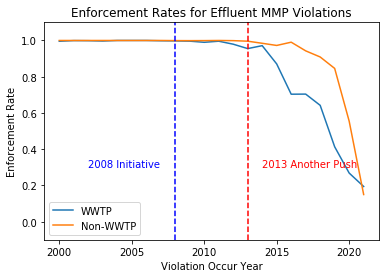

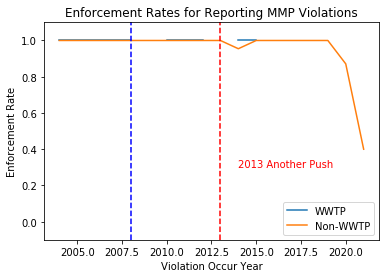

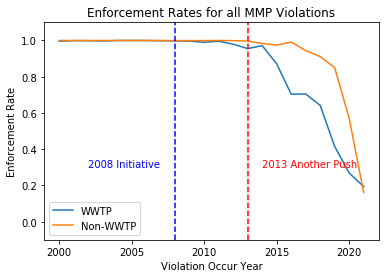

In [1394]:
plot_enf_rate_wwtp('Effluent')
plot_enf_rate_wwtp('Reporting')
enf_rate = plot_enf_rate_wwtp('all')

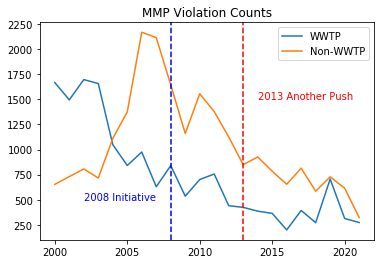

In [1397]:
# plot MMP violation counts by wwtp permits and others 
plt.title('MMP Violation Counts')
plt.plot(enf_rate.violation_year, enf_rate['WWTP_viol'])
plt.plot(enf_rate.violation_year, enf_rate['Non-WWTP_viol'])
plt.legend(['WWTP', 'Non-WWTP'])
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, 500), color = 'blue')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2013 Another Push', (2014, 1500), color = 'red')
plt.show()

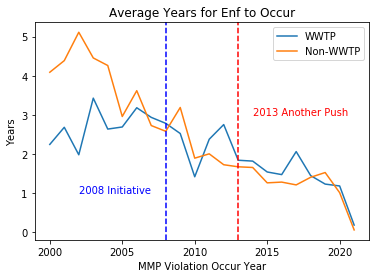

In [1398]:
# plot time to enforcements by WWTP permits and others
matched_trim_grouped['wwtp_flag'] = matched_trim_grouped.PROGRAM == 'NPDMUNILRG'
enf_time = matched_trim_grouped[matched_trim_grouped.mmp_flag].groupby(['violation_year', 'wwtp_flag'])['days_to_enf'].mean().to_frame().reset_index()
enf_time['years_to_enf'] = enf_time.days_to_enf/365

plt.title('Average Years for Enf to Occur')
plt.plot(enf_time[enf_time.wwtp_flag].violation_year, enf_time[enf_time.wwtp_flag].years_to_enf)
plt.plot(enf_time[~enf_time.wwtp_flag].violation_year, enf_time[~enf_time.wwtp_flag].years_to_enf)
plt.xlabel('MMP Violation Occur Year')
plt.ylabel('Years')
plt.legend(['WWTP', 'Non-WWTP'])
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, 1), color = 'blue')
plt.axvline(x = 2013,color = 'red',linestyle = '--')
plt.annotate('2013 Another Push', (2014, 3), color = 'red')
plt.show()

> Time it takes for enforcement to occur for both WWTP and non-WWTP permits are pretty similar after 2007. 

> Both WWTP and non-MMP permits MMP violations are enforced around 2007. 

#### Check dates when MMP was first implemented for individual facilities

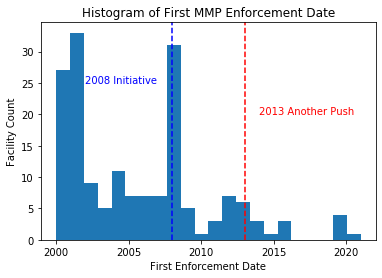

In [1406]:
eff_mmp = matched_trim[(matched_trim.mmp_flag) & (matched_trim.enforced_flag) & (matched_trim['EA Effective Date'] >= pd.to_datetime('2000'))]
first_enf_date = eff_mmp.groupby(['WDID_x', 'region_group', 'wwtp_flag'])['enforcement_year'].min().to_frame().reset_index()
first_enf_date = first_enf_date.rename(columns={'enforcement_year': 'first_mmp_enf_date'})

plt.title('Histogram of First MMP Enforcement Date')
plt.hist(first_enf_date[first_enf_date.wwtp_flag].first_mmp_enf_date, bins = len(eff_mmp.enforcement_year.unique()))
plt.xlabel('First Enforcement Date')
plt.ylabel('Facility Count')
plt.axvline(x = 2008, color = 'blue', linestyle = '--')
plt.annotate('2008 Initiative', (2002, 25), color = 'blue')
plt.axvline(x = 2013, color = 'red',linestyle = '--')
plt.annotate('2013 Another Push', (2014, 20), color = 'red')
plt.show()

> Most WWTP actually have MMP enforcements before 2007. We should investigate pre-2000 violation rates to see whether there are suggestive results also.

#### WWTP MMP Violation Rates

In [1408]:
# violation rates conditional on WWTP that were always active throughout the period

wwtp['active_before_2008'] = wwtp.start_date <= pd.to_datetime('2008-01-01')
wwtp['active_after_2008'] = wwtp.end_date >= pd.to_datetime('2008-01-01')
sum(wwtp.active_before_2008 & wwtp.active_after_2008)/len(wwtp)

0.8173913043478261

> about 82% of WWTP were active before and after 2008

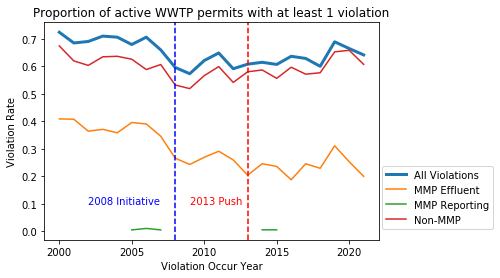

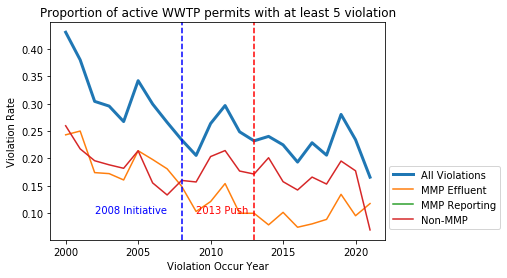

In [1409]:
wwtp_consistent = wwtp[wwtp.active_before_2008 & wwtp.active_after_2008]

viol_count_wwtp_consistent = npdes_viol[npdes_viol.WDID_x.isin(wwtp_consistent.WDID)].groupby(['region_group', 'WDID_x', 'violation_year', 'violation_category', 'mmp_flag', 'enforced_flag'])['VIOLATION ID (VID)'].count().to_frame().reset_index()
viol_count_wwtp_consistent = viol_count_wwtp_consistent.rename(columns = {'VIOLATION ID (VID)': 'violation_count'})

years = range(2000, 2022, 1)
counts = []
for y in years:
    y_start = dt.datetime(y, 1, 1)
    y_end = dt.datetime(y, 12, 30)
    wwtp_consistent['active_flag'] = (wwtp_consistent.start_date <= y_end) & ((wwtp_consistent.end_date >= y_start) | (pd.isnull(wwtp_consistent.end_date)))
    df = wwtp_consistent.groupby(['Region'])['active_flag'].sum().to_frame().reset_index()
    df = df.rename(columns = {'active_flag': 'permit_count'})
    df['year'] = y
    df = df[['year', 'Region', 'permit_count']]
    counts.append(df)
wwtp_count_consistent = pd.concat(counts)

plot_overall_violation_rates(viol_count_df = viol_count_wwtp_consistent, viol_count_threshold = 1, permit_count_df = wwtp_count_consistent, permit_type = 'WWTP')
plot_overall_violation_rates(viol_count_df = viol_count_wwtp_consistent, viol_count_threshold = 5, permit_count_df = wwtp_count_consistent, permit_type = 'WWTP')

In [1084]:
wwtp_count_consistent

,year,Region,permit_count
0,2000,1,12.0
1,2000,2,44.0
2,2000,3,16.0
3,2000,4,25.0
4,2000,5F,5.0
...,...,...,...
7,2021,6T,0.0
8,2021,6V,1.0
9,2021,7,8.0
10,2021,8,3.0


> Violation rates conditional on WWTP that were active before 2007 and after 2007 also show suggestive signal of MMP initiative.

#### Distribution of violation counts

In [1110]:
viol_count = pd.merge(viol_count, matched_trim[['WDID_x', 'wwtp_flag']].drop_duplicates(), how = 'left')
viol_count


,region_group,WDID_x,violation_year,violation_category,mmp_flag,enforced_flag,violation_count,wwtp_flag
0,Other,2 386065001,2010,Other,False,False,1,False
1,Other,2 386065001,2012,Effluent,False,False,1,False
2,Other,2 386065001,2012,Other,False,False,1,False
3,Other,3 400107001,2006,Other,False,False,14,True
4,Other,3 440102001,2005,Other,False,False,1,True
...,...,...,...,...,...,...,...,...
20789,Region 9,9 000003166,2018,Reporting,False,True,1,False
20790,Region 9,9 000003166,2019,Reporting,False,True,1,False
20791,Region 9,9 000003206,2017,Reporting,False,True,1,False
20792,Region 9,9 000003206,2018,Reporting,False,True,4,False


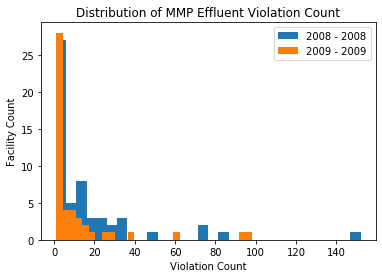

Ks_2sampResult(statistic=0.23214285714285715, pvalue=0.10393104637143502)


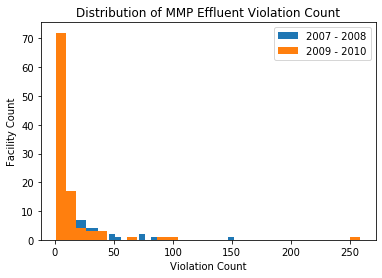

Ks_2sampResult(statistic=0.12750303398058252, pvalue=0.2799525902891542)


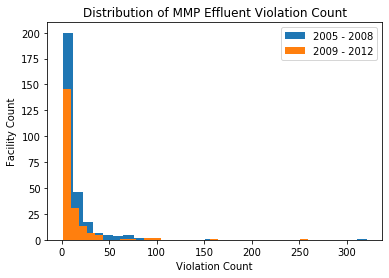

Ks_2sampResult(statistic=0.11814137419673752, pvalue=0.06052864275174674)


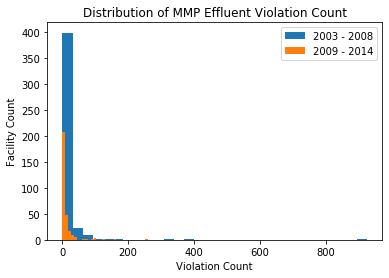

Ks_2sampResult(statistic=0.10435393692274426, pvalue=0.038945648220455764)


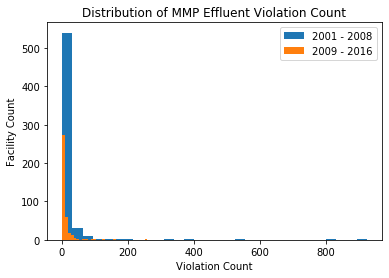

Ks_2sampResult(statistic=0.12644155936040752, pvalue=0.0010573812948773131)


In [1410]:
df = viol_count[(viol_count.violation_category == 'Effluent') & (viol_count.mmp_flag) & (viol_count.wwtp_flag)]

def plot_viol_count_dist(t, window):
    lower = t - window
    upper = t + window + 1
    df['pre_2007'] = (df.violation_year <= t) & (df.violation_year >= lower)
    df['post_2007'] = (df.violation_year <= upper) & (df.violation_year >= t+1)

    plt.title('Distribution of MMP Effluent Violation Count')
    plt.hist(df[df.pre_2007].violation_count, bins = 30)
    plt.hist(df[df.post_2007].violation_count, bins = 30)
    plt.xlabel('Violation Count')
    plt.ylabel('Facility Count')
    plt.legend([f'{lower} - {t}', f'{t+1} - {upper}'])
    plt.show()
    
    print(stats.ks_2samp(df[df.pre_2007].violation_count, df[df.post_2007].violation_count))

plot_viol_count_dist(t = 2008, window = 0)
plot_viol_count_dist(t = 2008, window = 1)
plot_viol_count_dist(t = 2008, window = 3)
plot_viol_count_dist(t = 2008, window = 5)
plot_viol_count_dist(t = 2008, window = 7)

> The KS test shows that the distributions of violation counts before and after 2007 are not significantly different from each other. 

### Regional rates

In [1085]:
permit_count['region_group'] = ['Region 2, 3, 4, 5' if r in ['2', '3', '4', '5S', '5R', '5F'] else 'Other' for r in permit_count.Region]
permit_count_r = permit_count.groupby(['region_group', 'year'])['permit_count'].sum().to_frame().reset_index()
permit_count_r = permit_count_r.rename(columns = {'year': 'violation_year'})

wwtp_count['region_group'] = ['Region 2, 3, 4, 5' if r in ['2', '3', '4', '5S', '5R', '5F'] else 'Other' for r in wwtp_count.Region]
wwtp_count_r = wwtp_count.groupby(['region_group', 'year'])['permit_count'].sum().to_frame().reset_index()
wwtp_count_r = wwtp_count_r.rename(columns = {'year': 'violation_year'})

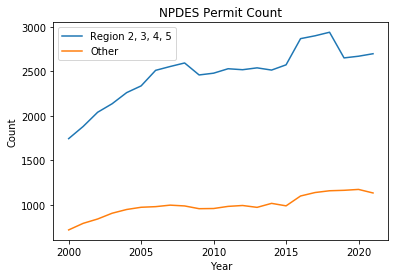

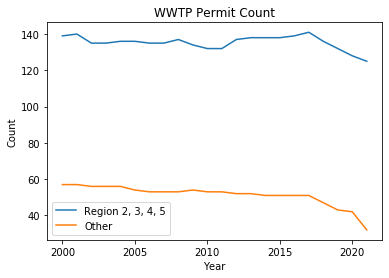

In [1422]:
# plot permit counts 
def plot_permit_counts(permit_count_df, permit_type):
    plt.title(f'{permit_type} Permit Count')
    for r in ['Region 2, 3, 4, 5', 'Other']:
        sub_df = permit_count_df[permit_count_df.region_group == r]
        plt.plot(sub_df.violation_year, sub_df.permit_count)
    plt.xlabel('Year')
    plt.ylabel('Count')
    plt.legend(['Region 2, 3, 4, 5', 'Other'])
    plt.show()
    
plot_permit_counts(permit_count_r, permit_type = 'NPDES')
plot_permit_counts(wwtp_count_r, permit_type = 'WWTP')

In [1429]:
def plot_regional_rates(viol_count_df, permit_count_df, violation_type, permit_type, viol_count_threshold = 1):
    if violation_type == 'MMP':
        viol_df = viol_count_df[viol_count_df.mmp_flag]
    elif violation_type == 'Effluent MMP':
        viol_df = viol_count_df[(viol_count_df.mmp_flag) & (viol_count_df.violation_category == 'Effluent')]
    elif violation_type == 'Reporting MMP':
        viol_df = viol_count_df[(viol_count_df.mmp_flag) & (viol_count_df.violation_category == 'Reporting')]
    elif violation_type == 'Non-MMP':
        viol_df = viol_count_df[~viol_count_df.mmp_flag]
    
    viol_df = viol_df[viol_df.violation_count >= viol_count_threshold]
    
    df = viol_df.groupby(['region_group', 'WDID_x', 'violation_year'])['violation_count'].sum().to_frame().reset_index().groupby(['region_group', 'violation_year'])['WDID_x'].count().to_frame().reset_index()
    df = df.rename(columns = {'WDID_x': 'violator_count'})
    plot_df = pd.merge(permit_count_df, df, how = 'left')
    plot_df.violator_count = plot_df.violator_count.fillna(0)
    plot_df['mmp_violation_rate'] = plot_df.violator_count/plot_df.permit_count

    r_groups = ['Region 2, 3, 4, 5', 'Other']
    for r in r_groups: 
        sub_df = plot_df[plot_df.region_group == r]
        plt.plot(sub_df.violation_year, sub_df.mmp_violation_rate)
    plt.title(f'Proportion of {permit_type} Permits With \nAt Least {viol_count_threshold} {violation_type} Violation')
    plt.axvline(x = 2008, color = 'red', linestyle = '--')
    plt.axvline(x = 2013,color = 'blue',linestyle = '--')
#     plt.annotate('2008 Initiative', (2002, 0.01), color = 'blue')
#     plt.annotate('2013 Another Push', (2014, 0.01), color = 'red')
    plt.xlabel('Violation Occur Year')
    plt.ylabel('Violation Rate')
    plt.legend(r_groups)
    plt.show()                                   

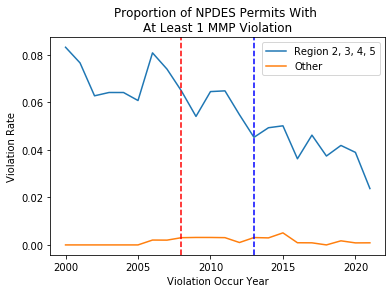

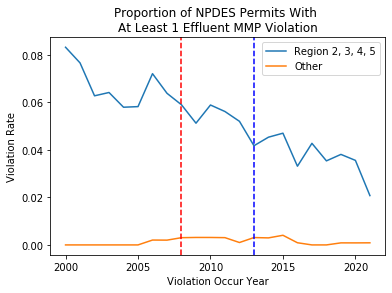

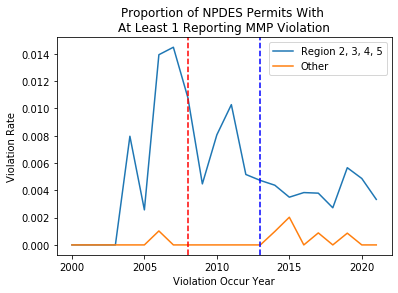

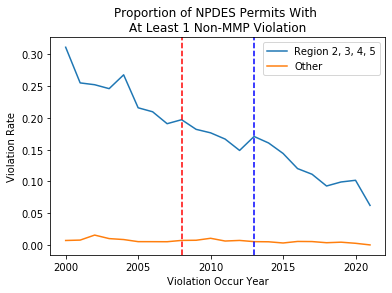

In [1430]:
# all npdes active permits
plot_regional_rates(viol_count_df = viol_count, permit_count_df = permit_count_r, violation_type = 'MMP', permit_type = 'NPDES')
plot_regional_rates(viol_count_df = viol_count, permit_count_df = permit_count_r, violation_type = 'Effluent MMP', permit_type = 'NPDES')
plot_regional_rates(viol_count_df = viol_count, permit_count_df = permit_count_r, violation_type = 'Reporting MMP', permit_type = 'NPDES')
plot_regional_rates(viol_count_df = viol_count, permit_count_df = permit_count_r, violation_type = 'Non-MMP', permit_type = 'NPDES')

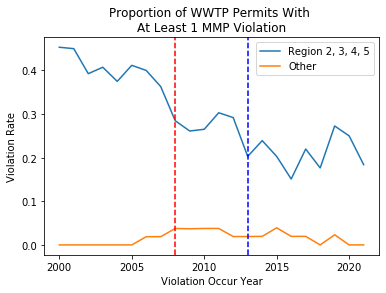

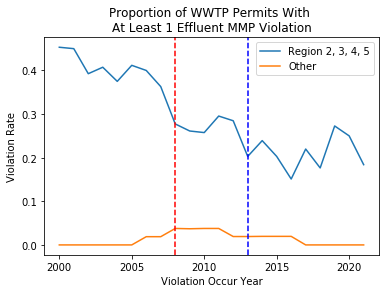

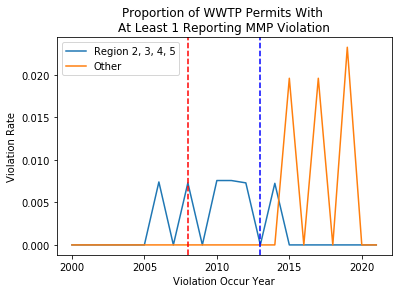

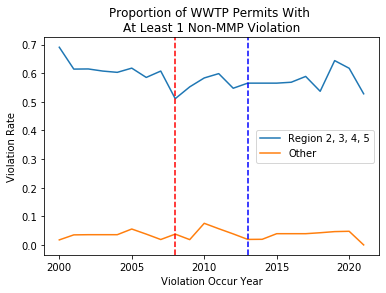

In [1431]:
# all wwtp active permits
plot_regional_rates(viol_count_df = viol_count_wwtp, permit_count_df = wwtp_count_r, violation_type = 'MMP', permit_type = 'WWTP')
plot_regional_rates(viol_count_df = viol_count_wwtp, permit_count_df = wwtp_count_r, violation_type = 'Effluent MMP', permit_type = 'WWTP')
plot_regional_rates(viol_count_df = viol_count_wwtp, permit_count_df = wwtp_count_r, violation_type = 'Reporting MMP', permit_type = 'WWTP')
plot_regional_rates(viol_count_df = viol_count_wwtp, permit_count_df = wwtp_count_r, violation_type = 'Non-MMP', permit_type = 'WWTP')

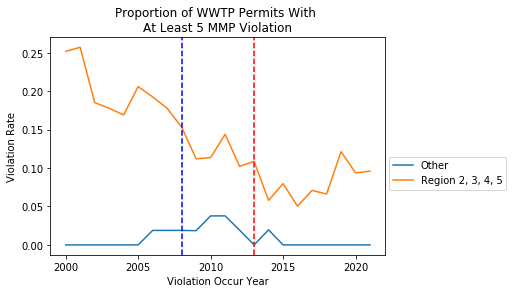

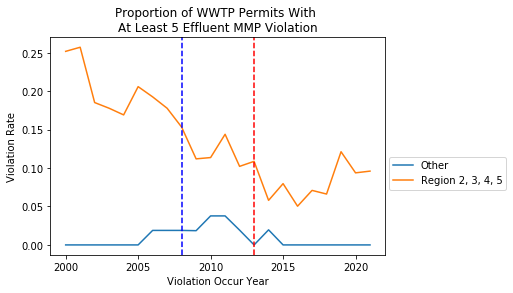

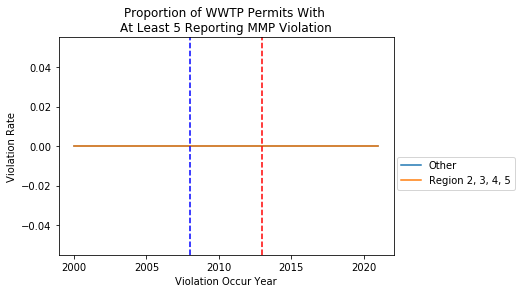

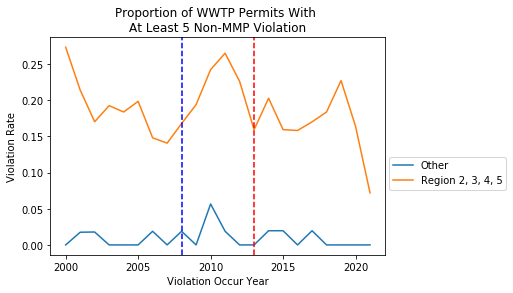

In [1420]:
# all wwtp active permits
plot_regional_rates(viol_count_df = viol_count_wwtp, permit_count_df = wwtp_count_r, violation_type = 'MMP', permit_type = 'WWTP', viol_count_threshold = 5)
plot_regional_rates(viol_count_df = viol_count_wwtp, permit_count_df = wwtp_count_r, violation_type = 'Effluent MMP', permit_type = 'WWTP', viol_count_threshold = 5)
plot_regional_rates(viol_count_df = viol_count_wwtp, permit_count_df = wwtp_count_r, violation_type = 'Reporting MMP', permit_type = 'WWTP', viol_count_threshold = 5)
plot_regional_rates(viol_count_df = viol_count_wwtp, permit_count_df = wwtp_count_r, violation_type = 'Non-MMP', permit_type = 'WWTP', viol_count_threshold = 5)

In [1297]:
# save processed violation and facility data for modeling
data_output_dir = os.path.join('~', 'sherlock_oak', 'EPA', 'Data', 'processed', 'california')
save_date = dt.datetime.today().strftime('%Y-%m-%d')
matched_trim.to_csv(os.path.join(data_output_dir, f'violations_{save_date}.csv'), index=False)

sc_period['region_group'] = ['Region 2, 3, 4, 5' if r in ['2', '3', '4', '5S', '5R', '5F'] else 'Other' for r in sc_period.Region]
sc_period['end_date'] = sc_period.end_date.fillna(dt.date.today())
sc_period['end_date'] = pd.to_datetime(sc_period.end_date)
sc_period['active_days'] = sc_period.end_date - sc_period.start_date
sc_period['active_days'] = sc_period.active_days/np.timedelta64(1, 'D')
sc_period['active_years'] = sc_period.active_days/365
sc_period['wwtp_flag'] = sc_period.Program == 'NPDMUNILRG'
sc_period.to_csv(os.path.join(data_output_dir, f'facilities_{save_date}.csv'), index=False)

wwtp_consistent.to_csv(os.path.join(data_output_dir, f'wwtp_consistent_{save_date}.csv'), index=False)
